##Connect Drive

In [1]:
# path_root = '/content/drive/MyDrive/datas/'
path_root = '/Users/sanghunoh/Develops/repository/own/study_machinglearning/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/Users/sanghunoh/Develops/repository/own/study_machinglearning/datas


In [2]:
# !unzip -o ./mpie_30_shuffle.zip -d ./mpie_30_shuffle

In [3]:
!ls

HW3Data_1.mat                           iris.zip
HW4_COIL20.mat                          mpie_30_shuffle
HW5Data_1.mat                           mpie_30_shuffle.zip
HW5Data_2.mat                           results_MLP_202205301020.pickle
README.md                               results_MLP_label_0_202205301020.pickle
dataCh4_7.zip                           results_MLP_label_3_202205301020.pickle
digitimages_binary.zip                  results_MLP_label_5_202205301020.pickle


###Load Dataset

In [4]:
path = path_root + 'mpie_30_shuffle/'

def loadDatasetFromCSV(_datafilename, _labelfilename, label_column):
  _feature_csv = pd.read_csv(path + _datafilename, dtype=np.float32, header=None) # image features of train data
  _feature_flatten = _feature_csv.values.flatten()
  _feature_reshape = np.reshape(_feature_flatten, (_feature_csv.shape[0], 32,-1))

  _label_csv = pd.read_csv(path + _labelfilename, dtype=np.float32, header=None) # labels of train data
  # print(f'_label_csv : {_label_csv.shape}')
  _label = _label_csv[label_column] # get label you want

  return _feature_reshape, _label

In [5]:
import pandas as pd
import numpy as np

# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', 0)
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', 0)

train_feature_reshape.shape, train_label.shape, validation_feature_reshape.shape, validation_label.shape

((18777, 32, 32), (18777,), (5086, 32, 32), (5086,))

In [6]:
np.unique(train_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.], dtype=float32)

In [7]:
import tensorflow as tf

def preprocessDataset(features_reshape, labels, batch_size=64, shuffle_buffer_size=100):
  _batch_size = batch_size
  _shuffle_buffer_size = shuffle_buffer_size

  _features = features_reshape
  _labels = labels
  _dataset_tensors = tf.data.Dataset.from_tensor_slices((_features, _labels))

  if _shuffle_buffer_size == None:
    _dataset_tensors = _dataset_tensors.batch(_batch_size)
  else :
    _dataset_tensors = _dataset_tensors.shuffle(_shuffle_buffer_size).batch(_batch_size)

  return _dataset_tensors

In [8]:
train_dataset = preprocessDataset(train_feature_reshape, train_label)
train_dataset

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-30 14:42:00.172785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-30 14:42:00.172874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<BatchDataset shapes: ((None, 32, 32), (None,)), types: (tf.float32, tf.float32)>

In [9]:
# train_dataset?

In [10]:
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)
validation_dataset

<BatchDataset shapes: ((None, 32, 32), (None,)), types: (tf.float32, tf.float32)>

###Deep CNN with BatchNormalization

In [11]:
filters = 32
_filters = filters
_min_filters = 16
_hidden_layers = int(_filters / _min_filters)
for layer in range(_hidden_layers):
  print(f'decrease : {_filters}')
  _filters = int(_filters/2)
  if _filters < _min_filters:
    break

for layer in range(_hidden_layers):
  _filters = int(_filters*2)
  if _filters > filters:
    break
  print(f'increase : {_filters}')


decrease : 32
decrease : 16
increase : 16
increase : 32


In [12]:
from tensorflow.keras import layers

category_count = train_label.unique().shape[0]
def make_model(_class_cnt, filters=16, _padding='same', _kernel_initializer='he_normal'
      , _activation='relu', _optimizer='SGD', _kernel_size = (3,3), _strides = (1,1)
      , pool_type='max', batch_normal=True, _pool_size = (2,2), epochs=2, label_class=0):
    model = tf.keras.Sequential()

    _filters = filters
    _min_filters = 16
    _hidden_layers = int(_filters / _min_filters)

    for layer in range(_hidden_layers):
      model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size
                              , strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
      model.add(layers.Activation(_activation))
      if batch_normal:
        model.add(layers.BatchNormalization())
      if pool_type == 'max':
        model.add(layers.MaxPooling2D(pool_size = _pool_size, padding = _padding, strides=_strides))
      else :
        model.add(layers.AveragePooling2D(pool_size = _pool_size, padding = _padding, strides=_strides))

      _filters = int(_filters/2)
      if _filters < _min_filters:
        break

    # ?전 Layer에서 filter size 작아져 실행 않됨
    # for layer in range(_hidden_layers):
    #   _filters = int(_filters*2)
    #   if _filters > filters:
    #     break
    #   model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size, strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
    #   model.add(layers.Activation(_activation))
    #   if BatchNormal:
    #     model.add(layers.BatchNormalization())
    #   model.add(layers.MaxPooling2D(pool_size = _pool_size))

    # prior layer should be flattend to be connected to dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = _activation, kernel_initializer=_kernel_initializer))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(_class_cnt, activation = 'softmax', kernel_initializer=_kernel_initializer))

    # adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = _optimizer, metrics = ['accuracy'])

    return model

In [13]:
model = make_model(_class_cnt=6, pool_type='max')    
# tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True) #layer_range=?, 

###callback function for fit time

In [14]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
TimeHistory()

### fit model

In [15]:
_epochs = 10
# _batch_size = int(len(list(train_dataset)) / (len(list(train_dataset))/2))   # Just Check Model params quickly
_batch_size = len(list(train_dataset))

def model_fit(_param, _train_dataset, _validation_dataset):
  tf.keras.backend.clear_session()

  model = make_model(**_param)
  time_callback = TimeHistory()
  history = model.fit(_train_dataset, epochs=_param['epochs'], validation_data=_validation_dataset, callbacks=[time_callback], steps_per_epoch=_batch_size)
  execution_time = sum(time_callback.times)
  return model, history, execution_time, _param

In [16]:
label_class = 0
# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class)
class_cnt = len(np.unique(train_label))
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class)

train_dataset = preprocessDataset(train_feature_reshape, train_label)
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

param = {'_class_cnt':class_cnt, 'epochs':2, 'label_class':label_class, '_kernel_initializer':None
         , '_activation':'sigmoid', 'batch_normal':False, '_optimizer':'RMSprop', 'filters':16 , '_padding':'valid'
         , 'pool_type':'max', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)}

model_fit(param, train_dataset, validation_dataset)

Epoch 1/2


2022-05-30 14:42:01.967055: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-30 14:42:01.967128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 3.5380 - accuracy: 0.0402

2022-05-30 14:42:05.875957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 14ms/step - loss: 3.5375 - accuracy: 0.0402 - val_loss: 3.3903 - val_accuracy: 0.0370
Epoch 2/2
294/294 [==============================] - 4s 14ms/step - loss: 3.4588 - accuracy: 0.0347 - val_loss: 3.3898 - val_accuracy: 0.0370


(<keras.engine.sequential.Sequential at 0x299017640>,
 8.500140190124512,
 {'_class_cnt': 30,
  'epochs': 2,
  'label_class': 0,
  '_kernel_initializer': None,
  '_activation': 'sigmoid',
  'batch_normal': False,
  '_optimizer': 'RMSprop',
  'filters': 16,
  '_padding': 'valid',
  'pool_type': 'max',
  '_kernel_size': (3, 3),
  '_strides': (1, 1),
  '_pool_size': (2, 2)})

### fit with multi params
filters : larger than 16

In [17]:
param = {'_class_cnt':class_cnt, 'epochs':2, 'label_class':label_class, '_kernel_initializer':None
         , '_activation':'sigmoid', 'batch_normal':False, '_optimizer':'Nadam', 'filters':16 , '_padding':'same'
         , 'pool_type':'average', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)}


In [18]:
# param 6
params = list()
param_key_list = list(param.keys())
# epochs_list = [10, 40]
# _kernel_initializer_list = [None, 'he_normal']
# _activation_list = ['sigmoid', 'relu']
# _optimizer_list= ['Adam', 'Nadam']
# batch_normal_list = [False, True]
# filters_list = [8, 32]
# _padding_list = ['same', 'valid']
# _kernel_size_list = [(3,3), (5,5)]
# _strides_list = [(1,1), (3,3)]
# pool_type_list = ['average', 'max']
epochs_list = [10, 30]
_kernel_initializer_list = ['he_normal']
_activation_list = ['relu']
_optimizer_list= ['Nadam']
batch_normal_list = [True]
filters_list = [8, 16]
_padding_list = ['same', 'valid']
_kernel_size_list = [(3,3), (5,5)]
_strides_list = [(1,1), (3,3)]
pool_type_list = ['average', 'max']


for filters in filters_list:
  for _padding in _padding_list:
    for _kernel_initializer in _kernel_initializer_list:
      for _activation in _activation_list:
        for _optimizer in _optimizer_list:
          for batch_normal in batch_normal_list:
            for epochs in epochs_list:
              for _kernel_size in _kernel_size_list:
                for _strides in _strides_list:
                  for pool_type in pool_type_list:
                    param_dict = dict()
                    param_dict['filters'] = filters
                    param_dict['_padding'] = _padding
                    param_dict['_kernel_initializer'] = _kernel_initializer
                    param_dict['_activation'] = _activation
                    param_dict['_optimizer'] = _optimizer
                    param_dict['batch_normal'] = batch_normal
                    param_dict['epochs'] = epochs
                    param_dict['_kernel_size'] = _kernel_size
                    param_dict['_strides'] = _strides
                    param_dict['pool_type'] = pool_type
                    # print(param_dict)
                    params.append(param_dict)
len(params)

64

In [19]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y%m%d%H%M")
print("date and time =", dt_string)

import pickle

now = 2022-05-30 14:42:10.421631
date and time = 202205301442


In [20]:
# params = params[5:7]
label_classes = [1, 2, 4]
results_list = list()
for label_class in label_classes:
  train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class)
  class_cnt = len(np.unique(train_label))
  # test
  validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class)

  train_dataset = preprocessDataset(train_feature_reshape, train_label)
  validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

  results = list()          
  for idx, param in enumerate(params):
    param['_class_cnt'] = class_cnt
    param['label_class'] = label_class
    print('-'*5 +'[ '+ str(idx) + ' ]'+ '-'*5 + str(param))
    results.append(model_fit(param, train_dataset, validation_dataset))
  # save
  with open(f'results_CNN_label_{label_class}_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
  results_list = results_list + results


-----[ 0 ]-----{'filters': 8, '_padding': 'same', '_kernel_initializer': 'he_normal', '_activation': 'relu', '_optimizer': 'Nadam', 'batch_normal': True, 'epochs': 10, '_kernel_size': (3, 3), '_strides': (1, 1), 'pool_type': 'average', '_class_cnt': 6, 'label_class': 1}
Epoch 1/10


2022-05-30 14:42:11.842207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3432 - accuracy: 0.5752

2022-05-30 14:42:14.079950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 7ms/step - loss: 1.3432 - accuracy: 0.5752 - val_loss: 1.2354 - val_accuracy: 0.5708
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1675 - accuracy: 0.6142 - val_loss: 1.1271 - val_accuracy: 0.6013
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0860 - accuracy: 0.6321 - val_loss: 1.0475 - val_accuracy: 0.6313
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0346 - accuracy: 0.6428 - val_loss: 0.9934 - val_accuracy: 0.6559
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9957 - accuracy: 0.6537 - val_loss: 0.9835 - val_accuracy: 0.6447
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9673 - accuracy: 0.6612 - val_loss: 1.0396 - val_accuracy: 0.6502
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9517 - accuracy: 0.6670 - val_loss: 0.9471 - val_accuracy: 0.6622
Epoch 8/10
294/29

2022-05-30 14:42:32.340998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.3428 - accuracy: 0.5706

2022-05-30 14:42:34.295546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3428 - accuracy: 0.5705 - val_loss: 1.2656 - val_accuracy: 0.5592
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1588 - accuracy: 0.6176 - val_loss: 1.2275 - val_accuracy: 0.5928
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0692 - accuracy: 0.6376 - val_loss: 1.0764 - val_accuracy: 0.6217
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0170 - accuracy: 0.6473 - val_loss: 1.1016 - val_accuracy: 0.6036
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9766 - accuracy: 0.6588 - val_loss: 0.9518 - val_accuracy: 0.6538
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9412 - accuracy: 0.6685 - val_loss: 0.9268 - val_accuracy: 0.6656
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9126 - accuracy: 0.6747 - val_loss: 0.9059 - val_accuracy: 0.6648
Epoch 8/10
294/29

2022-05-30 14:42:52.552500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 1.3320 - accuracy: 0.5786

2022-05-30 14:42:54.694902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3322 - accuracy: 0.5780 - val_loss: 1.2184 - val_accuracy: 0.5733
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1374 - accuracy: 0.6242 - val_loss: 1.0993 - val_accuracy: 0.6050
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0484 - accuracy: 0.6453 - val_loss: 1.0593 - val_accuracy: 0.6278
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9954 - accuracy: 0.6572 - val_loss: 0.9767 - val_accuracy: 0.6573
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9600 - accuracy: 0.6658 - val_loss: 0.9830 - val_accuracy: 0.6418
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9235 - accuracy: 0.6737 - val_loss: 0.9251 - val_accuracy: 0.6644
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8943 - accuracy: 0.6833 - val_loss: 0.9303 - val_accuracy: 0.6626
Epoch 8/10
294/29

2022-05-30 14:43:12.855536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.3299 - accuracy: 0.5771

2022-05-30 14:43:14.848214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3299 - accuracy: 0.5770 - val_loss: 1.2417 - val_accuracy: 0.5883
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1481 - accuracy: 0.6200 - val_loss: 1.1051 - val_accuracy: 0.6083
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0589 - accuracy: 0.6420 - val_loss: 1.0273 - val_accuracy: 0.6404
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0041 - accuracy: 0.6555 - val_loss: 1.0148 - val_accuracy: 0.6433
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9673 - accuracy: 0.6641 - val_loss: 0.9690 - val_accuracy: 0.6465
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9335 - accuracy: 0.6700 - val_loss: 0.9062 - val_accuracy: 0.6679
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9081 - accuracy: 0.6786 - val_loss: 0.9696 - val_accuracy: 0.6481
Epoch 8/10
294/29

2022-05-30 14:43:33.054266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


288/294 [============================>.] - ETA: 0s - loss: 1.3403 - accuracy: 0.5731

2022-05-30 14:43:34.953686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3403 - accuracy: 0.5722 - val_loss: 1.2615 - val_accuracy: 0.5531
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1591 - accuracy: 0.6178 - val_loss: 1.1742 - val_accuracy: 0.6278
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0728 - accuracy: 0.6384 - val_loss: 1.0682 - val_accuracy: 0.6309
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0267 - accuracy: 0.6504 - val_loss: 1.0330 - val_accuracy: 0.6410
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9837 - accuracy: 0.6615 - val_loss: 1.0265 - val_accuracy: 0.6555
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9456 - accuracy: 0.6723 - val_loss: 0.9345 - val_accuracy: 0.6479
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9251 - accuracy: 0.6781 - val_loss: 0.9439 - val_accuracy: 0.6571
Epoch 8/10
294/29

2022-05-30 14:43:53.228882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3348 - accuracy: 0.5733

2022-05-30 14:43:55.364430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3348 - accuracy: 0.5733 - val_loss: 1.2327 - val_accuracy: 0.5753
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1349 - accuracy: 0.6238 - val_loss: 1.0877 - val_accuracy: 0.6148
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0530 - accuracy: 0.6459 - val_loss: 1.0239 - val_accuracy: 0.6394
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0059 - accuracy: 0.6554 - val_loss: 1.0079 - val_accuracy: 0.6400
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9690 - accuracy: 0.6645 - val_loss: 0.9891 - val_accuracy: 0.6469
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9442 - accuracy: 0.6702 - val_loss: 0.9389 - val_accuracy: 0.6545
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9135 - accuracy: 0.6793 - val_loss: 0.8892 - val_accuracy: 0.6734
Epoch 8/10
294/29

2022-05-30 14:44:13.814597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.5708

2022-05-30 14:44:15.851290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3541 - accuracy: 0.5708 - val_loss: 1.2699 - val_accuracy: 0.5659
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1780 - accuracy: 0.6107 - val_loss: 1.1270 - val_accuracy: 0.6058
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0876 - accuracy: 0.6348 - val_loss: 1.0581 - val_accuracy: 0.6262
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0369 - accuracy: 0.6448 - val_loss: 1.0178 - val_accuracy: 0.6563
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9990 - accuracy: 0.6557 - val_loss: 1.0114 - val_accuracy: 0.6569
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9665 - accuracy: 0.6627 - val_loss: 0.9730 - val_accuracy: 0.6453
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9320 - accuracy: 0.6708 - val_loss: 0.9643 - val_accuracy: 0.6626
Epoch 8/10
294/29

2022-05-30 14:44:34.816640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.3423 - accuracy: 0.5707

2022-05-30 14:44:36.942337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3421 - accuracy: 0.5708 - val_loss: 1.2346 - val_accuracy: 0.5731
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1707 - accuracy: 0.6110 - val_loss: 1.1412 - val_accuracy: 0.6237
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0786 - accuracy: 0.6347 - val_loss: 1.0464 - val_accuracy: 0.6219
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0193 - accuracy: 0.6516 - val_loss: 1.0541 - val_accuracy: 0.6494
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9810 - accuracy: 0.6617 - val_loss: 0.9513 - val_accuracy: 0.6567
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9471 - accuracy: 0.6706 - val_loss: 0.9717 - val_accuracy: 0.6604
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9194 - accuracy: 0.6720 - val_loss: 0.8919 - val_accuracy: 0.6683
Epoch 8/10
294/29

2022-05-30 14:44:56.428707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


290/294 [============================>.] - ETA: 0s - loss: 1.3266 - accuracy: 0.5757

2022-05-30 14:44:58.452726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3262 - accuracy: 0.5757 - val_loss: 1.2641 - val_accuracy: 0.6017
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1272 - accuracy: 0.6244 - val_loss: 1.0955 - val_accuracy: 0.6072
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0438 - accuracy: 0.6488 - val_loss: 1.0203 - val_accuracy: 0.6437
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9931 - accuracy: 0.6609 - val_loss: 1.0690 - val_accuracy: 0.6319
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9541 - accuracy: 0.6730 - val_loss: 0.9596 - val_accuracy: 0.6451
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9244 - accuracy: 0.6757 - val_loss: 0.9266 - val_accuracy: 0.6695
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8967 - accuracy: 0.6829 - val_loss: 0.8815 - val_accuracy: 0.6736
Epoch 8/30
294/29

2022-05-30 14:45:59.157290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 1.3053 - accuracy: 0.5837

2022-05-30 14:46:01.384739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3051 - accuracy: 0.5836 - val_loss: 1.2113 - val_accuracy: 0.6054
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1122 - accuracy: 0.6307 - val_loss: 1.1189 - val_accuracy: 0.6192
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0378 - accuracy: 0.6490 - val_loss: 1.0380 - val_accuracy: 0.6308
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9951 - accuracy: 0.6556 - val_loss: 0.9827 - val_accuracy: 0.6392
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9576 - accuracy: 0.6670 - val_loss: 0.9748 - val_accuracy: 0.6392
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9250 - accuracy: 0.6757 - val_loss: 0.9226 - val_accuracy: 0.6809
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8990 - accuracy: 0.6801 - val_loss: 0.8964 - val_accuracy: 0.6795
Epoch 8/30
294/29

2022-05-30 14:47:02.083509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3196 - accuracy: 0.5808

2022-05-30 14:47:04.067006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3196 - accuracy: 0.5808 - val_loss: 1.2613 - val_accuracy: 0.6070
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1272 - accuracy: 0.6283 - val_loss: 1.1076 - val_accuracy: 0.6182
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0448 - accuracy: 0.6480 - val_loss: 1.0419 - val_accuracy: 0.6447
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9964 - accuracy: 0.6580 - val_loss: 0.9661 - val_accuracy: 0.6600
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9536 - accuracy: 0.6678 - val_loss: 0.9669 - val_accuracy: 0.6512
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9212 - accuracy: 0.6761 - val_loss: 1.0016 - val_accuracy: 0.6404
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8934 - accuracy: 0.6821 - val_loss: 0.8905 - val_accuracy: 0.6565
Epoch 8/30
294/29

2022-05-30 14:48:03.896282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


289/294 [============================>.] - ETA: 0s - loss: 1.3488 - accuracy: 0.5714

2022-05-30 14:48:05.979148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 1.3483 - accuracy: 0.5708 - val_loss: 1.2571 - val_accuracy: 0.5655
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1847 - accuracy: 0.6089 - val_loss: 1.1405 - val_accuracy: 0.6127
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0946 - accuracy: 0.6319 - val_loss: 1.1648 - val_accuracy: 0.5916
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0463 - accuracy: 0.6447 - val_loss: 1.0014 - val_accuracy: 0.6372
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0092 - accuracy: 0.6551 - val_loss: 1.0056 - val_accuracy: 0.6382
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9782 - accuracy: 0.6604 - val_loss: 0.9464 - val_accuracy: 0.6589
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9516 - accuracy: 0.6661 - val_loss: 0.9137 - val_accuracy: 0.6752
Epoch 8/30
294/29

2022-05-30 14:49:06.463320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 1.3351 - accuracy: 0.5748

2022-05-30 14:49:08.565525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 1.3351 - accuracy: 0.5749 - val_loss: 1.2288 - val_accuracy: 0.6034
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1531 - accuracy: 0.6196 - val_loss: 1.1312 - val_accuracy: 0.6017
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0632 - accuracy: 0.6398 - val_loss: 1.1601 - val_accuracy: 0.5902
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0195 - accuracy: 0.6488 - val_loss: 1.0090 - val_accuracy: 0.6427
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9827 - accuracy: 0.6600 - val_loss: 0.9478 - val_accuracy: 0.6646
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9539 - accuracy: 0.6655 - val_loss: 0.9410 - val_accuracy: 0.6734
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9291 - accuracy: 0.6704 - val_loss: 0.9404 - val_accuracy: 0.6479
Epoch 8/30
294/29

2022-05-30 14:50:08.966709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3181 - accuracy: 0.5790

2022-05-30 14:50:11.010202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3181 - accuracy: 0.5790 - val_loss: 1.1929 - val_accuracy: 0.5881
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1370 - accuracy: 0.6225 - val_loss: 1.0821 - val_accuracy: 0.6195
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0585 - accuracy: 0.6417 - val_loss: 1.0452 - val_accuracy: 0.6329
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0110 - accuracy: 0.6507 - val_loss: 1.0167 - val_accuracy: 0.6575
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9772 - accuracy: 0.6606 - val_loss: 0.9690 - val_accuracy: 0.6416
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9398 - accuracy: 0.6685 - val_loss: 0.9292 - val_accuracy: 0.6484
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9177 - accuracy: 0.6722 - val_loss: 0.8776 - val_accuracy: 0.6663
Epoch 8/30
294/29

2022-05-30 14:51:11.362164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3382 - accuracy: 0.5767

2022-05-30 14:51:13.479221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 1.3382 - accuracy: 0.5767 - val_loss: 1.2155 - val_accuracy: 0.6020
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1521 - accuracy: 0.6193 - val_loss: 1.1392 - val_accuracy: 0.6186
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0703 - accuracy: 0.6384 - val_loss: 1.0390 - val_accuracy: 0.6327
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0136 - accuracy: 0.6542 - val_loss: 0.9841 - val_accuracy: 0.6365
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9758 - accuracy: 0.6616 - val_loss: 0.9395 - val_accuracy: 0.6561
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9424 - accuracy: 0.6676 - val_loss: 0.9547 - val_accuracy: 0.6557
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9123 - accuracy: 0.6759 - val_loss: 0.9302 - val_accuracy: 0.6821
Epoch 8/30
294/29

2022-05-30 14:52:11.790937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


289/294 [============================>.] - ETA: 0s - loss: 1.3179 - accuracy: 0.5800

2022-05-30 14:52:13.944923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3174 - accuracy: 0.5798 - val_loss: 1.2684 - val_accuracy: 0.6182
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1377 - accuracy: 0.6212 - val_loss: 1.1644 - val_accuracy: 0.6192
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0639 - accuracy: 0.6388 - val_loss: 1.0534 - val_accuracy: 0.6445
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0188 - accuracy: 0.6497 - val_loss: 0.9938 - val_accuracy: 0.6390
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9784 - accuracy: 0.6582 - val_loss: 0.9699 - val_accuracy: 0.6540
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9565 - accuracy: 0.6652 - val_loss: 0.9429 - val_accuracy: 0.6579
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9218 - accuracy: 0.6740 - val_loss: 0.9184 - val_accuracy: 0.6638
Epoch 8/30
294/29

2022-05-30 14:53:13.654898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3165 - accuracy: 0.5776

2022-05-30 14:53:15.881733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3165 - accuracy: 0.5776 - val_loss: 1.1971 - val_accuracy: 0.5987
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1249 - accuracy: 0.6256 - val_loss: 1.0892 - val_accuracy: 0.6288
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0479 - accuracy: 0.6465 - val_loss: 1.1476 - val_accuracy: 0.6142
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9995 - accuracy: 0.6589 - val_loss: 1.0436 - val_accuracy: 0.6229
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9556 - accuracy: 0.6668 - val_loss: 1.0989 - val_accuracy: 0.6018
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9267 - accuracy: 0.6747 - val_loss: 0.8933 - val_accuracy: 0.6738
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9014 - accuracy: 0.6782 - val_loss: 0.8813 - val_accuracy: 0.6742
Epoch 8/10
294/29

2022-05-30 14:53:34.044407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


289/294 [============================>.] - ETA: 0s - loss: 1.3196 - accuracy: 0.5807

2022-05-30 14:53:36.005837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3188 - accuracy: 0.5802 - val_loss: 1.2226 - val_accuracy: 0.5708
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1419 - accuracy: 0.6236 - val_loss: 1.1123 - val_accuracy: 0.6197
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0711 - accuracy: 0.6391 - val_loss: 1.0533 - val_accuracy: 0.6416
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0257 - accuracy: 0.6514 - val_loss: 1.0202 - val_accuracy: 0.6392
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9951 - accuracy: 0.6584 - val_loss: 0.9731 - val_accuracy: 0.6632
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9688 - accuracy: 0.6657 - val_loss: 0.9430 - val_accuracy: 0.6608
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9331 - accuracy: 0.6717 - val_loss: 1.0084 - val_accuracy: 0.6378
Epoch 8/10
294/29

2022-05-30 14:53:54.739567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


290/294 [============================>.] - ETA: 0s - loss: 1.3056 - accuracy: 0.5863

2022-05-30 14:53:56.727750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3059 - accuracy: 0.5859 - val_loss: 1.2538 - val_accuracy: 0.6044
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1131 - accuracy: 0.6332 - val_loss: 1.0791 - val_accuracy: 0.6227
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0429 - accuracy: 0.6478 - val_loss: 1.0428 - val_accuracy: 0.6288
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9900 - accuracy: 0.6609 - val_loss: 1.0196 - val_accuracy: 0.6583
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9534 - accuracy: 0.6698 - val_loss: 0.9477 - val_accuracy: 0.6713
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9242 - accuracy: 0.6771 - val_loss: 0.9253 - val_accuracy: 0.6777
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9003 - accuracy: 0.6795 - val_loss: 0.8828 - val_accuracy: 0.6720
Epoch 8/10
294/29

2022-05-30 14:54:15.422919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3121 - accuracy: 0.5848

2022-05-30 14:54:17.382935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3121 - accuracy: 0.5848 - val_loss: 1.2053 - val_accuracy: 0.5981
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1212 - accuracy: 0.6302 - val_loss: 1.1583 - val_accuracy: 0.6072
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0445 - accuracy: 0.6472 - val_loss: 1.0874 - val_accuracy: 0.6146
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0003 - accuracy: 0.6570 - val_loss: 0.9820 - val_accuracy: 0.6630
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9643 - accuracy: 0.6635 - val_loss: 1.0305 - val_accuracy: 0.6536
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9325 - accuracy: 0.6722 - val_loss: 0.9386 - val_accuracy: 0.6579
Epoch 7/10
294/294 [==============================] - 2s 8ms/step - loss: 0.9080 - accuracy: 0.6808 - val_loss: 0.9336 - val_accuracy: 0.6591
Epoch 8/10
294/29

2022-05-30 14:54:36.639987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3254 - accuracy: 0.5825

2022-05-30 14:54:38.760164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 1.3254 - accuracy: 0.5825 - val_loss: 1.2421 - val_accuracy: 0.5934
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1402 - accuracy: 0.6228 - val_loss: 1.0938 - val_accuracy: 0.6390
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0606 - accuracy: 0.6432 - val_loss: 1.0410 - val_accuracy: 0.6349
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0196 - accuracy: 0.6509 - val_loss: 0.9840 - val_accuracy: 0.6524
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9831 - accuracy: 0.6591 - val_loss: 1.0207 - val_accuracy: 0.6540
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9539 - accuracy: 0.6662 - val_loss: 0.9459 - val_accuracy: 0.6589
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9300 - accuracy: 0.6687 - val_loss: 0.9032 - val_accuracy: 0.6762
Epoch 8/10
294/29

2022-05-30 14:54:57.246208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3228 - accuracy: 0.5819

2022-05-30 14:54:59.284471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3228 - accuracy: 0.5819 - val_loss: 1.3330 - val_accuracy: 0.5543
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1296 - accuracy: 0.6276 - val_loss: 1.0916 - val_accuracy: 0.6292
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0499 - accuracy: 0.6451 - val_loss: 1.0165 - val_accuracy: 0.6494
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0031 - accuracy: 0.6589 - val_loss: 1.0167 - val_accuracy: 0.6638
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9662 - accuracy: 0.6660 - val_loss: 0.9831 - val_accuracy: 0.6469
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9355 - accuracy: 0.6715 - val_loss: 0.9146 - val_accuracy: 0.6783
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9085 - accuracy: 0.6770 - val_loss: 0.9018 - val_accuracy: 0.6675
Epoch 8/10
294/29

2022-05-30 14:55:18.263890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


288/294 [============================>.] - ETA: 0s - loss: 1.3341 - accuracy: 0.5769

2022-05-30 14:55:20.274697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3344 - accuracy: 0.5764 - val_loss: 1.2261 - val_accuracy: 0.5973
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1484 - accuracy: 0.6208 - val_loss: 1.1027 - val_accuracy: 0.6329
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0700 - accuracy: 0.6383 - val_loss: 1.1057 - val_accuracy: 0.6329
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0188 - accuracy: 0.6513 - val_loss: 1.0008 - val_accuracy: 0.6315
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9781 - accuracy: 0.6601 - val_loss: 0.9472 - val_accuracy: 0.6650
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9442 - accuracy: 0.6707 - val_loss: 0.9099 - val_accuracy: 0.6644
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9163 - accuracy: 0.6731 - val_loss: 0.9150 - val_accuracy: 0.6734
Epoch 8/10
294/29

2022-05-30 14:55:39.351730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3415 - accuracy: 0.5759

2022-05-30 14:55:41.368388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3415 - accuracy: 0.5759 - val_loss: 1.2923 - val_accuracy: 0.5708
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.1586 - accuracy: 0.6180 - val_loss: 1.1472 - val_accuracy: 0.5912
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0816 - accuracy: 0.6341 - val_loss: 1.0859 - val_accuracy: 0.6437
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0311 - accuracy: 0.6477 - val_loss: 1.0125 - val_accuracy: 0.6235
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9896 - accuracy: 0.6552 - val_loss: 0.9843 - val_accuracy: 0.6667
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9633 - accuracy: 0.6642 - val_loss: 0.9507 - val_accuracy: 0.6571
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9390 - accuracy: 0.6685 - val_loss: 0.9183 - val_accuracy: 0.6520
Epoch 8/10
294/29

2022-05-30 14:55:59.758460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3335 - accuracy: 0.5760

2022-05-30 14:56:01.989056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3335 - accuracy: 0.5760 - val_loss: 1.2168 - val_accuracy: 0.5840
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1385 - accuracy: 0.6242 - val_loss: 1.0821 - val_accuracy: 0.6319
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0624 - accuracy: 0.6416 - val_loss: 1.0462 - val_accuracy: 0.6290
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0123 - accuracy: 0.6531 - val_loss: 1.0220 - val_accuracy: 0.6304
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9742 - accuracy: 0.6622 - val_loss: 0.9735 - val_accuracy: 0.6388
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9407 - accuracy: 0.6677 - val_loss: 0.9036 - val_accuracy: 0.6730
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9200 - accuracy: 0.6744 - val_loss: 0.9202 - val_accuracy: 0.6571
Epoch 8/30
294/29

2022-05-30 14:57:00.969916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.3453 - accuracy: 0.5744

2022-05-30 14:57:02.881426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3450 - accuracy: 0.5745 - val_loss: 1.2580 - val_accuracy: 0.5676
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1441 - accuracy: 0.6207 - val_loss: 1.1841 - val_accuracy: 0.6052
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0519 - accuracy: 0.6461 - val_loss: 1.0283 - val_accuracy: 0.6329
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0095 - accuracy: 0.6539 - val_loss: 0.9815 - val_accuracy: 0.6500
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9747 - accuracy: 0.6646 - val_loss: 1.0089 - val_accuracy: 0.6518
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9402 - accuracy: 0.6715 - val_loss: 0.9208 - val_accuracy: 0.6622
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9129 - accuracy: 0.6778 - val_loss: 0.9031 - val_accuracy: 0.6471
Epoch 8/30
294/29

2022-05-30 14:58:01.530133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


289/294 [============================>.] - ETA: 0s - loss: 1.3456 - accuracy: 0.5747

2022-05-30 14:58:03.675507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3455 - accuracy: 0.5742 - val_loss: 1.2552 - val_accuracy: 0.5838
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1616 - accuracy: 0.6158 - val_loss: 1.1085 - val_accuracy: 0.6457
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0713 - accuracy: 0.6400 - val_loss: 1.0697 - val_accuracy: 0.6433
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0156 - accuracy: 0.6543 - val_loss: 0.9867 - val_accuracy: 0.6496
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9803 - accuracy: 0.6618 - val_loss: 0.9717 - val_accuracy: 0.6469
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9501 - accuracy: 0.6690 - val_loss: 0.9247 - val_accuracy: 0.6740
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9156 - accuracy: 0.6779 - val_loss: 0.8802 - val_accuracy: 0.6779
Epoch 8/30
294/29

2022-05-30 14:59:04.626793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


289/294 [============================>.] - ETA: 0s - loss: 1.3303 - accuracy: 0.5761

2022-05-30 14:59:06.732681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 1.3302 - accuracy: 0.5757 - val_loss: 1.2316 - val_accuracy: 0.5641
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1495 - accuracy: 0.6183 - val_loss: 1.1376 - val_accuracy: 0.5926
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0607 - accuracy: 0.6427 - val_loss: 1.0628 - val_accuracy: 0.6184
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0016 - accuracy: 0.6579 - val_loss: 0.9882 - val_accuracy: 0.6355
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9653 - accuracy: 0.6658 - val_loss: 1.0247 - val_accuracy: 0.6626
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9310 - accuracy: 0.6749 - val_loss: 0.8973 - val_accuracy: 0.6718
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8996 - accuracy: 0.6836 - val_loss: 0.8991 - val_accuracy: 0.6636
Epoch 8/30
294/29

2022-05-30 15:00:06.848301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.3319 - accuracy: 0.5784

2022-05-30 15:00:09.057019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3318 - accuracy: 0.5784 - val_loss: 1.2524 - val_accuracy: 0.5902
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1577 - accuracy: 0.6119 - val_loss: 1.1238 - val_accuracy: 0.6203
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0767 - accuracy: 0.6288 - val_loss: 1.0498 - val_accuracy: 0.6264
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0289 - accuracy: 0.6415 - val_loss: 1.0368 - val_accuracy: 0.6604
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9929 - accuracy: 0.6546 - val_loss: 1.0343 - val_accuracy: 0.6368
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9553 - accuracy: 0.6637 - val_loss: 0.9397 - val_accuracy: 0.6541
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9335 - accuracy: 0.6678 - val_loss: 0.9237 - val_accuracy: 0.6616
Epoch 8/30
294/29

2022-05-30 15:01:09.357320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 1.3293 - accuracy: 0.5744

2022-05-30 15:01:11.464060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 1.3292 - accuracy: 0.5739 - val_loss: 1.2443 - val_accuracy: 0.5904
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1609 - accuracy: 0.6178 - val_loss: 1.1311 - val_accuracy: 0.5983
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0767 - accuracy: 0.6359 - val_loss: 1.0538 - val_accuracy: 0.6339
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0324 - accuracy: 0.6465 - val_loss: 1.0676 - val_accuracy: 0.6524
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9949 - accuracy: 0.6540 - val_loss: 0.9759 - val_accuracy: 0.6484
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9632 - accuracy: 0.6622 - val_loss: 0.9850 - val_accuracy: 0.6406
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9360 - accuracy: 0.6689 - val_loss: 0.9180 - val_accuracy: 0.6750
Epoch 8/30
294/29

2022-05-30 15:02:12.479115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3099 - accuracy: 0.5803

2022-05-30 15:02:14.640312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3099 - accuracy: 0.5803 - val_loss: 1.2017 - val_accuracy: 0.5830
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1248 - accuracy: 0.6225 - val_loss: 1.0754 - val_accuracy: 0.6182
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0464 - accuracy: 0.6444 - val_loss: 1.0089 - val_accuracy: 0.6422
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9989 - accuracy: 0.6542 - val_loss: 0.9850 - val_accuracy: 0.6439
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9581 - accuracy: 0.6651 - val_loss: 0.9462 - val_accuracy: 0.6559
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9353 - accuracy: 0.6701 - val_loss: 0.9233 - val_accuracy: 0.6595
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9030 - accuracy: 0.6747 - val_loss: 0.9060 - val_accuracy: 0.6608
Epoch 8/30
294/29

2022-05-30 15:03:14.839192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


288/294 [============================>.] - ETA: 0s - loss: 1.3512 - accuracy: 0.5702

2022-05-30 15:03:16.820864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 1.3502 - accuracy: 0.5701 - val_loss: 1.2673 - val_accuracy: 0.5535
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.1624 - accuracy: 0.6177 - val_loss: 1.2268 - val_accuracy: 0.6158
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0715 - accuracy: 0.6406 - val_loss: 1.0541 - val_accuracy: 0.6256
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0177 - accuracy: 0.6521 - val_loss: 0.9957 - val_accuracy: 0.6563
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9811 - accuracy: 0.6644 - val_loss: 0.9604 - val_accuracy: 0.6587
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9457 - accuracy: 0.6695 - val_loss: 0.9280 - val_accuracy: 0.6644
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9224 - accuracy: 0.6774 - val_loss: 0.9083 - val_accuracy: 0.6701
Epoch 8/30
294/29

2022-05-30 15:04:15.235367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3106 - accuracy: 0.5972

2022-05-30 15:04:19.918930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 17ms/step - loss: 1.3106 - accuracy: 0.5972 - val_loss: 1.2029 - val_accuracy: 0.6494
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.9296 - accuracy: 0.6633 - val_loss: 0.8291 - val_accuracy: 0.6888
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.8185 - accuracy: 0.6824 - val_loss: 0.6710 - val_accuracy: 0.7063
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.7399 - accuracy: 0.6987 - val_loss: 0.5632 - val_accuracy: 0.7517
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.6692 - accuracy: 0.7221 - val_loss: 0.5058 - val_accuracy: 0.7792
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.6249 - accuracy: 0.7346 - val_loss: 0.4816 - val_accuracy: 0.7829
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.5987 - accuracy: 0.7410 - val_loss: 0.4676 - val_accuracy: 0.7963
Epoch 8/10

2022-05-30 15:05:03.032242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.1533 - accuracy: 0.6335

2022-05-30 15:05:07.980185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 1.1530 - accuracy: 0.6336 - val_loss: 1.1423 - val_accuracy: 0.6522
Epoch 2/10
294/294 [==============================] - 5s 17ms/step - loss: 0.7240 - accuracy: 0.7246 - val_loss: 0.5941 - val_accuracy: 0.7666
Epoch 3/10
294/294 [==============================] - 5s 17ms/step - loss: 0.5838 - accuracy: 0.7728 - val_loss: 0.4608 - val_accuracy: 0.8142
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.4829 - accuracy: 0.8063 - val_loss: 0.3868 - val_accuracy: 0.8557
Epoch 5/10
294/294 [==============================] - 5s 17ms/step - loss: 0.4225 - accuracy: 0.8309 - val_loss: 0.3271 - val_accuracy: 0.8685
Epoch 6/10
294/294 [==============================] - 5s 17ms/step - loss: 0.3779 - accuracy: 0.8508 - val_loss: 0.3267 - val_accuracy: 0.8712
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.3376 - accuracy: 0.8665 - val_loss: 0.3023 - val_accuracy: 0.8897
Epoch 8/10

2022-05-30 15:05:54.156458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.3588 - accuracy: 0.5596

2022-05-30 15:05:57.247849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.3585 - accuracy: 0.5595 - val_loss: 1.3512 - val_accuracy: 0.5792
Epoch 2/10
294/294 [==============================] - 3s 9ms/step - loss: 1.1409 - accuracy: 0.6157 - val_loss: 1.1229 - val_accuracy: 0.6048
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0522 - accuracy: 0.6371 - val_loss: 1.0201 - val_accuracy: 0.6288
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9949 - accuracy: 0.6548 - val_loss: 0.9714 - val_accuracy: 0.6459
Epoch 5/10
294/294 [==============================] - 3s 9ms/step - loss: 0.9440 - accuracy: 0.6661 - val_loss: 0.9295 - val_accuracy: 0.6573
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9079 - accuracy: 0.6750 - val_loss: 0.9149 - val_accuracy: 0.6648
Epoch 7/10
294/294 [==============================] - 3s 9ms/step - loss: 0.8729 - accuracy: 0.6879 - val_loss: 0.8656 - val_accuracy: 0.6772
Epoch 8/10
29

2022-05-30 15:06:23.298548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.4636 - accuracy: 0.5367

2022-05-30 15:06:26.293054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 10ms/step - loss: 1.4636 - accuracy: 0.5367 - val_loss: 1.3890 - val_accuracy: 0.5488
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 1.2043 - accuracy: 0.6014 - val_loss: 1.1752 - val_accuracy: 0.5959
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 1.1131 - accuracy: 0.6194 - val_loss: 1.0808 - val_accuracy: 0.6131
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0510 - accuracy: 0.6346 - val_loss: 1.0241 - val_accuracy: 0.6229
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0037 - accuracy: 0.6488 - val_loss: 0.9877 - val_accuracy: 0.6370
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9685 - accuracy: 0.6585 - val_loss: 0.9460 - val_accuracy: 0.6524
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9246 - accuracy: 0.6691 - val_loss: 0.8978 - val_accuracy: 0.6659
Epoch 8/10

2022-05-30 15:06:53.251489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2585 - accuracy: 0.5966

2022-05-30 15:06:58.196279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 1.2585 - accuracy: 0.5966 - val_loss: 1.1697 - val_accuracy: 0.6412
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.9444 - accuracy: 0.6446 - val_loss: 0.8017 - val_accuracy: 0.6736
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.8092 - accuracy: 0.6802 - val_loss: 0.5868 - val_accuracy: 0.7471
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.7053 - accuracy: 0.7156 - val_loss: 0.5316 - val_accuracy: 0.7764
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.6256 - accuracy: 0.7489 - val_loss: 0.4434 - val_accuracy: 0.8227
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.5759 - accuracy: 0.7650 - val_loss: 0.4047 - val_accuracy: 0.8313
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.5337 - accuracy: 0.7832 - val_loss: 0.4051 - val_accuracy: 0.8335
Epoch 8/10

2022-05-30 15:07:42.096208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.2794 - accuracy: 0.5960

2022-05-30 15:07:47.078722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 1.2792 - accuracy: 0.5960 - val_loss: 1.1458 - val_accuracy: 0.6563
Epoch 2/10
294/294 [==============================] - 5s 17ms/step - loss: 0.9104 - accuracy: 0.6562 - val_loss: 0.7378 - val_accuracy: 0.7106
Epoch 3/10
294/294 [==============================] - 5s 17ms/step - loss: 0.8048 - accuracy: 0.6806 - val_loss: 0.6636 - val_accuracy: 0.7304
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.7381 - accuracy: 0.6992 - val_loss: 0.5264 - val_accuracy: 0.7597
Epoch 5/10
294/294 [==============================] - 5s 18ms/step - loss: 0.6689 - accuracy: 0.7216 - val_loss: 0.4870 - val_accuracy: 0.7910
Epoch 6/10
294/294 [==============================] - 5s 17ms/step - loss: 0.6226 - accuracy: 0.7426 - val_loss: 0.4584 - val_accuracy: 0.8008
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.5728 - accuracy: 0.7648 - val_loss: 0.4061 - val_accuracy: 0.8323
Epoch 8/10

2022-05-30 15:08:34.115238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.3017 - accuracy: 0.5772

2022-05-30 15:08:37.393670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.3014 - accuracy: 0.5773 - val_loss: 1.3966 - val_accuracy: 0.6038
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0620 - accuracy: 0.6387 - val_loss: 1.0413 - val_accuracy: 0.6337
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9580 - accuracy: 0.6630 - val_loss: 0.9090 - val_accuracy: 0.6591
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.8819 - accuracy: 0.6847 - val_loss: 0.8416 - val_accuracy: 0.6815
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.8216 - accuracy: 0.7021 - val_loss: 0.8097 - val_accuracy: 0.7047
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.7734 - accuracy: 0.7181 - val_loss: 0.7605 - val_accuracy: 0.7173
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.7307 - accuracy: 0.7346 - val_loss: 0.7362 - val_accuracy: 0.7251
Epoch 8/10

2022-05-30 15:09:04.112724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3532 - accuracy: 0.5676

2022-05-30 15:09:07.063814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 10ms/step - loss: 1.3532 - accuracy: 0.5676 - val_loss: 1.3336 - val_accuracy: 0.5920
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 1.0886 - accuracy: 0.6303 - val_loss: 1.0383 - val_accuracy: 0.6355
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9950 - accuracy: 0.6567 - val_loss: 0.9411 - val_accuracy: 0.6571
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9296 - accuracy: 0.6707 - val_loss: 0.9040 - val_accuracy: 0.6781
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.8717 - accuracy: 0.6919 - val_loss: 0.8474 - val_accuracy: 0.6895
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.8348 - accuracy: 0.7009 - val_loss: 0.8057 - val_accuracy: 0.6990
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.7849 - accuracy: 0.7142 - val_loss: 0.7748 - val_accuracy: 0.7145
Epoch 8/10

2022-05-30 15:09:34.915966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2972 - accuracy: 0.5941

2022-05-30 15:09:39.740754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 17ms/step - loss: 1.2972 - accuracy: 0.5941 - val_loss: 1.3062 - val_accuracy: 0.5956
Epoch 2/30
294/294 [==============================] - 5s 17ms/step - loss: 0.9807 - accuracy: 0.6467 - val_loss: 0.8301 - val_accuracy: 0.6911
Epoch 3/30
294/294 [==============================] - 5s 16ms/step - loss: 0.8957 - accuracy: 0.6607 - val_loss: 0.7426 - val_accuracy: 0.6846
Epoch 4/30
294/294 [==============================] - 5s 16ms/step - loss: 0.8422 - accuracy: 0.6724 - val_loss: 0.7474 - val_accuracy: 0.6974
Epoch 5/30
294/294 [==============================] - 5s 16ms/step - loss: 0.8070 - accuracy: 0.6792 - val_loss: 0.6566 - val_accuracy: 0.7151
Epoch 6/30
294/294 [==============================] - 5s 16ms/step - loss: 0.7754 - accuracy: 0.6878 - val_loss: 0.6056 - val_accuracy: 0.7202
Epoch 7/30
294/294 [==============================] - 5s 16ms/step - loss: 0.7392 - accuracy: 0.6974 - val_loss: 0.6002 - val_accuracy: 0.7202
Epoch 8/30

2022-05-30 15:12:01.890326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.4053 - accuracy: 0.5781

2022-05-30 15:12:06.914758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 1.4049 - accuracy: 0.5782 - val_loss: 1.2931 - val_accuracy: 0.6030
Epoch 2/30
294/294 [==============================] - 5s 17ms/step - loss: 0.8638 - accuracy: 0.6809 - val_loss: 0.6627 - val_accuracy: 0.7413
Epoch 3/30
294/294 [==============================] - 5s 17ms/step - loss: 0.7317 - accuracy: 0.7167 - val_loss: 0.5302 - val_accuracy: 0.7782
Epoch 4/30
294/294 [==============================] - 5s 17ms/step - loss: 0.6288 - accuracy: 0.7444 - val_loss: 0.5066 - val_accuracy: 0.7818
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.5709 - accuracy: 0.7703 - val_loss: 0.4060 - val_accuracy: 0.8380
Epoch 6/30
294/294 [==============================] - 5s 17ms/step - loss: 0.5261 - accuracy: 0.7851 - val_loss: 0.3680 - val_accuracy: 0.8474
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.4878 - accuracy: 0.7979 - val_loss: 0.3566 - val_accuracy: 0.8478
Epoch 8/30

2022-05-30 15:14:34.092290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3358 - accuracy: 0.5686

2022-05-30 15:14:37.529022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.3358 - accuracy: 0.5686 - val_loss: 1.4152 - val_accuracy: 0.5547
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 1.1440 - accuracy: 0.6144 - val_loss: 1.1485 - val_accuracy: 0.6097
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0662 - accuracy: 0.6299 - val_loss: 1.0450 - val_accuracy: 0.6221
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0067 - accuracy: 0.6465 - val_loss: 0.9849 - val_accuracy: 0.6386
Epoch 5/30
294/294 [==============================] - 3s 9ms/step - loss: 0.9605 - accuracy: 0.6582 - val_loss: 0.9414 - val_accuracy: 0.6540
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.9154 - accuracy: 0.6713 - val_loss: 0.9055 - val_accuracy: 0.6669
Epoch 7/30
294/294 [==============================] - 3s 9ms/step - loss: 0.8831 - accuracy: 0.6826 - val_loss: 0.8851 - val_accuracy: 0.6718
Epoch 8/30
2

2022-05-30 15:16:00.645610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 1.4673 - accuracy: 0.5373

2022-05-30 15:16:03.863529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.4664 - accuracy: 0.5374 - val_loss: 1.4393 - val_accuracy: 0.5448
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 1.2249 - accuracy: 0.5984 - val_loss: 1.1887 - val_accuracy: 0.5847
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 1.1257 - accuracy: 0.6163 - val_loss: 1.1017 - val_accuracy: 0.6032
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0607 - accuracy: 0.6298 - val_loss: 1.0576 - val_accuracy: 0.6164
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0161 - accuracy: 0.6394 - val_loss: 1.0287 - val_accuracy: 0.6268
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.9796 - accuracy: 0.6515 - val_loss: 0.9966 - val_accuracy: 0.6363
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.9380 - accuracy: 0.6625 - val_loss: 0.9424 - val_accuracy: 0.6512
Epoch 8/30

2022-05-30 15:17:29.600032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.2172 - accuracy: 0.5959

2022-05-30 15:17:34.523474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 1.2172 - accuracy: 0.5958 - val_loss: 1.1276 - val_accuracy: 0.6791
Epoch 2/30
294/294 [==============================] - 5s 17ms/step - loss: 0.8557 - accuracy: 0.6785 - val_loss: 0.6809 - val_accuracy: 0.7471
Epoch 3/30
294/294 [==============================] - 5s 17ms/step - loss: 0.7227 - accuracy: 0.7215 - val_loss: 0.5299 - val_accuracy: 0.7762
Epoch 4/30
294/294 [==============================] - 5s 17ms/step - loss: 0.6081 - accuracy: 0.7629 - val_loss: 0.4586 - val_accuracy: 0.8010
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.5430 - accuracy: 0.7868 - val_loss: 0.3897 - val_accuracy: 0.8462
Epoch 6/30
294/294 [==============================] - 5s 17ms/step - loss: 0.4888 - accuracy: 0.8044 - val_loss: 0.3471 - val_accuracy: 0.8706
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.4463 - accuracy: 0.8219 - val_loss: 0.3472 - val_accuracy: 0.8651
Epoch 8/30

2022-05-30 15:19:57.621870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.2553 - accuracy: 0.6121

2022-05-30 15:20:02.899517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 1.2551 - accuracy: 0.6120 - val_loss: 1.1703 - val_accuracy: 0.6569
Epoch 2/30
294/294 [==============================] - 5s 18ms/step - loss: 0.8302 - accuracy: 0.6782 - val_loss: 0.6863 - val_accuracy: 0.7420
Epoch 3/30
294/294 [==============================] - 5s 18ms/step - loss: 0.7051 - accuracy: 0.7179 - val_loss: 0.5395 - val_accuracy: 0.7873
Epoch 4/30
294/294 [==============================] - 6s 20ms/step - loss: 0.6336 - accuracy: 0.7366 - val_loss: 0.4664 - val_accuracy: 0.8114
Epoch 5/30
294/294 [==============================] - 6s 19ms/step - loss: 0.5717 - accuracy: 0.7592 - val_loss: 0.6191 - val_accuracy: 0.7715
Epoch 6/30
294/294 [==============================] - 5s 18ms/step - loss: 0.5370 - accuracy: 0.7761 - val_loss: 0.4249 - val_accuracy: 0.8474
Epoch 7/30
294/294 [==============================] - 5s 18ms/step - loss: 0.4881 - accuracy: 0.7895 - val_loss: 0.3850 - val_accuracy: 0.8527
Epoch 8/30

2022-05-30 15:22:45.633209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3292 - accuracy: 0.5665

2022-05-30 15:22:48.804895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.3292 - accuracy: 0.5665 - val_loss: 1.3930 - val_accuracy: 0.5975
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0724 - accuracy: 0.6355 - val_loss: 1.0382 - val_accuracy: 0.6365
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.9630 - accuracy: 0.6635 - val_loss: 0.9329 - val_accuracy: 0.6618
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.8950 - accuracy: 0.6794 - val_loss: 0.8562 - val_accuracy: 0.6803
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.8389 - accuracy: 0.6962 - val_loss: 0.8115 - val_accuracy: 0.6996
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.7930 - accuracy: 0.7110 - val_loss: 0.7674 - val_accuracy: 0.7090
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.7460 - accuracy: 0.7266 - val_loss: 0.7372 - val_accuracy: 0.7283
Epoch 8/30

2022-05-30 15:24:14.690913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.4046 - accuracy: 0.5557

2022-05-30 15:24:17.664931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 10ms/step - loss: 1.4046 - accuracy: 0.5557 - val_loss: 1.3461 - val_accuracy: 0.5753
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 1.1229 - accuracy: 0.6204 - val_loss: 1.0724 - val_accuracy: 0.6239
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0098 - accuracy: 0.6481 - val_loss: 0.9718 - val_accuracy: 0.6388
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.9262 - accuracy: 0.6691 - val_loss: 0.9059 - val_accuracy: 0.6620
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.8730 - accuracy: 0.6868 - val_loss: 0.8426 - val_accuracy: 0.6827
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.8180 - accuracy: 0.7037 - val_loss: 0.7969 - val_accuracy: 0.6998
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.7763 - accuracy: 0.7161 - val_loss: 0.7592 - val_accuracy: 0.7114
Epoch 8/30

2022-05-30 15:25:43.738082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3268 - accuracy: 0.6156

2022-05-30 15:25:49.069777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 1.3268 - accuracy: 0.6156 - val_loss: 1.0763 - val_accuracy: 0.6612
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.7585 - accuracy: 0.7205 - val_loss: 0.6330 - val_accuracy: 0.7717
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.6161 - accuracy: 0.7633 - val_loss: 0.4828 - val_accuracy: 0.8164
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.5335 - accuracy: 0.7903 - val_loss: 0.4186 - val_accuracy: 0.8354
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.4411 - accuracy: 0.8216 - val_loss: 0.3636 - val_accuracy: 0.8539
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.3927 - accuracy: 0.8413 - val_loss: 0.3126 - val_accuracy: 0.8720
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.3513 - accuracy: 0.8572 - val_loss: 0.2692 - val_accuracy: 0.8976
Epoch 8/10

2022-05-30 15:26:31.658432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 1.0746 - accuracy: 0.6501

2022-05-30 15:26:36.328532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 17ms/step - loss: 1.0725 - accuracy: 0.6507 - val_loss: 1.0763 - val_accuracy: 0.7177
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.5982 - accuracy: 0.7724 - val_loss: 0.4810 - val_accuracy: 0.8315
Epoch 3/10
294/294 [==============================] - 5s 15ms/step - loss: 0.4641 - accuracy: 0.8175 - val_loss: 0.3531 - val_accuracy: 0.8691
Epoch 4/10
294/294 [==============================] - 5s 15ms/step - loss: 0.3825 - accuracy: 0.8526 - val_loss: 0.3246 - val_accuracy: 0.8730
Epoch 5/10
294/294 [==============================] - 5s 15ms/step - loss: 0.3237 - accuracy: 0.8748 - val_loss: 0.2633 - val_accuracy: 0.9025
Epoch 6/10
294/294 [==============================] - 5s 15ms/step - loss: 0.2820 - accuracy: 0.8898 - val_loss: 0.2598 - val_accuracy: 0.9003
Epoch 7/10
294/294 [==============================] - 5s 15ms/step - loss: 0.2557 - accuracy: 0.9018 - val_loss: 0.2252 - val_accuracy: 0.9162
Epoch 8/10

2022-05-30 15:27:18.249488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.4437 - accuracy: 0.5367

2022-05-30 15:27:21.839762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.4437 - accuracy: 0.5367 - val_loss: 1.4122 - val_accuracy: 0.5385
Epoch 2/10
294/294 [==============================] - 3s 9ms/step - loss: 1.2941 - accuracy: 0.5722 - val_loss: 1.3011 - val_accuracy: 0.5454
Epoch 3/10
294/294 [==============================] - 3s 9ms/step - loss: 1.2411 - accuracy: 0.5807 - val_loss: 1.2429 - val_accuracy: 0.5619
Epoch 4/10
294/294 [==============================] - 3s 9ms/step - loss: 1.1959 - accuracy: 0.5898 - val_loss: 1.2042 - val_accuracy: 0.5682
Epoch 5/10
294/294 [==============================] - 3s 9ms/step - loss: 1.1605 - accuracy: 0.5978 - val_loss: 1.1620 - val_accuracy: 0.5871
Epoch 6/10
294/294 [==============================] - 3s 9ms/step - loss: 1.1271 - accuracy: 0.6052 - val_loss: 1.1234 - val_accuracy: 0.5863
Epoch 7/10
294/294 [==============================] - 3s 9ms/step - loss: 1.0939 - accuracy: 0.6160 - val_loss: 1.0978 - val_accuracy: 0.5997
Epoch 8/10
294/2

2022-05-30 15:27:47.126486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.5677 - accuracy: 0.5125

2022-05-30 15:27:50.212614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.5677 - accuracy: 0.5125 - val_loss: 1.4539 - val_accuracy: 0.5391
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 1.3417 - accuracy: 0.5682 - val_loss: 1.3331 - val_accuracy: 0.5448
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 1.2885 - accuracy: 0.5743 - val_loss: 1.2917 - val_accuracy: 0.5501
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 1.2497 - accuracy: 0.5794 - val_loss: 1.2600 - val_accuracy: 0.5588
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 1.2218 - accuracy: 0.5852 - val_loss: 1.2350 - val_accuracy: 0.5645
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 1.1919 - accuracy: 0.5897 - val_loss: 1.2124 - val_accuracy: 0.5720
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 1.1716 - accuracy: 0.5962 - val_loss: 1.1919 - val_accuracy: 0.5739
Epoch 8/10

2022-05-30 15:28:17.761570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1171 - accuracy: 0.6409

2022-05-30 15:28:22.770403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 1.1171 - accuracy: 0.6409 - val_loss: 0.9859 - val_accuracy: 0.7110
Epoch 2/10
294/294 [==============================] - 4s 15ms/step - loss: 0.6522 - accuracy: 0.7460 - val_loss: 0.4955 - val_accuracy: 0.8067
Epoch 3/10
294/294 [==============================] - 4s 15ms/step - loss: 0.5130 - accuracy: 0.7974 - val_loss: 0.3804 - val_accuracy: 0.8439
Epoch 4/10
294/294 [==============================] - 4s 15ms/step - loss: 0.4302 - accuracy: 0.8281 - val_loss: 0.3652 - val_accuracy: 0.8632
Epoch 5/10
294/294 [==============================] - 4s 14ms/step - loss: 0.3611 - accuracy: 0.8589 - val_loss: 0.2923 - val_accuracy: 0.8901
Epoch 6/10
294/294 [==============================] - 4s 15ms/step - loss: 0.3220 - accuracy: 0.8736 - val_loss: 0.2436 - val_accuracy: 0.9109
Epoch 7/10
294/294 [==============================] - 4s 14ms/step - loss: 0.2838 - accuracy: 0.8850 - val_loss: 0.2337 - val_accuracy: 0.9172
Epoch 8/10

2022-05-30 15:29:02.184209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.0906 - accuracy: 0.6472

2022-05-30 15:29:06.563819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 16ms/step - loss: 1.0900 - accuracy: 0.6473 - val_loss: 1.0036 - val_accuracy: 0.7355
Epoch 2/10
294/294 [==============================] - 4s 15ms/step - loss: 0.6490 - accuracy: 0.7491 - val_loss: 0.5335 - val_accuracy: 0.7973
Epoch 3/10
294/294 [==============================] - 4s 15ms/step - loss: 0.5390 - accuracy: 0.7853 - val_loss: 0.3966 - val_accuracy: 0.8407
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.4476 - accuracy: 0.8192 - val_loss: 0.3681 - val_accuracy: 0.8514
Epoch 5/10
294/294 [==============================] - 5s 15ms/step - loss: 0.4017 - accuracy: 0.8373 - val_loss: 0.3688 - val_accuracy: 0.8600
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.3612 - accuracy: 0.8516 - val_loss: 0.2874 - val_accuracy: 0.8934
Epoch 7/10
294/294 [==============================] - 4s 15ms/step - loss: 0.3259 - accuracy: 0.8695 - val_loss: 0.2730 - val_accuracy: 0.8964
Epoch 8/10

2022-05-30 15:29:47.862809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 1.3614 - accuracy: 0.5625

2022-05-30 15:29:51.028993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.3606 - accuracy: 0.5627 - val_loss: 1.3884 - val_accuracy: 0.5572
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 1.1646 - accuracy: 0.6155 - val_loss: 1.1702 - val_accuracy: 0.6015
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0846 - accuracy: 0.6314 - val_loss: 1.0816 - val_accuracy: 0.6195
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0283 - accuracy: 0.6442 - val_loss: 1.0270 - val_accuracy: 0.6296
Epoch 5/10
294/294 [==============================] - 4s 13ms/step - loss: 0.9866 - accuracy: 0.6529 - val_loss: 1.0249 - val_accuracy: 0.6294
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9446 - accuracy: 0.6642 - val_loss: 1.0527 - val_accuracy: 0.6264
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9178 - accuracy: 0.6718 - val_loss: 0.9745 - val_accuracy: 0.6481
Epoch 8/10

2022-05-30 15:30:19.662874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.5017 - accuracy: 0.5376

2022-05-30 15:30:22.622264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 10ms/step - loss: 1.5015 - accuracy: 0.5377 - val_loss: 1.4247 - val_accuracy: 0.5391
Epoch 2/10
294/294 [==============================] - 3s 9ms/step - loss: 1.2786 - accuracy: 0.5875 - val_loss: 1.2832 - val_accuracy: 0.5667
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: 1.2158 - accuracy: 0.6005 - val_loss: 1.2151 - val_accuracy: 0.5840
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 1.1717 - accuracy: 0.6090 - val_loss: 1.1796 - val_accuracy: 0.5930
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 1.1247 - accuracy: 0.6219 - val_loss: 1.1368 - val_accuracy: 0.6007
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0898 - accuracy: 0.6294 - val_loss: 1.0891 - val_accuracy: 0.6158
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 1.0525 - accuracy: 0.6393 - val_loss: 1.0577 - val_accuracy: 0.6260
Epoch 8/10


2022-05-30 15:30:49.722816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1643 - accuracy: 0.6371

2022-05-30 15:30:54.384040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 16ms/step - loss: 1.1643 - accuracy: 0.6371 - val_loss: 1.0393 - val_accuracy: 0.7133
Epoch 2/30
294/294 [==============================] - 4s 15ms/step - loss: 0.6579 - accuracy: 0.7576 - val_loss: 0.5501 - val_accuracy: 0.8136
Epoch 3/30
294/294 [==============================] - 4s 15ms/step - loss: 0.5321 - accuracy: 0.7948 - val_loss: 0.3914 - val_accuracy: 0.8519
Epoch 4/30
294/294 [==============================] - 4s 15ms/step - loss: 0.4361 - accuracy: 0.8312 - val_loss: 0.3390 - val_accuracy: 0.8681
Epoch 5/30
294/294 [==============================] - 4s 15ms/step - loss: 0.3657 - accuracy: 0.8572 - val_loss: 0.2859 - val_accuracy: 0.8889
Epoch 6/30
294/294 [==============================] - 4s 15ms/step - loss: 0.3218 - accuracy: 0.8749 - val_loss: 0.2453 - val_accuracy: 0.9131
Epoch 7/30
294/294 [==============================] - 4s 15ms/step - loss: 0.2958 - accuracy: 0.8809 - val_loss: 0.2515 - val_accuracy: 0.9066
Epoch 8/30

2022-05-30 15:33:07.219260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6728

2022-05-30 15:33:12.428297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.9607 - accuracy: 0.6728 - val_loss: 0.9454 - val_accuracy: 0.7247
Epoch 2/30
294/294 [==============================] - 5s 17ms/step - loss: 0.5649 - accuracy: 0.7803 - val_loss: 0.5039 - val_accuracy: 0.8299
Epoch 3/30
294/294 [==============================] - 5s 18ms/step - loss: 0.4361 - accuracy: 0.8274 - val_loss: 0.3269 - val_accuracy: 0.8740
Epoch 4/30
294/294 [==============================] - 5s 18ms/step - loss: 0.3702 - accuracy: 0.8568 - val_loss: 0.2698 - val_accuracy: 0.9039
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.3255 - accuracy: 0.8742 - val_loss: 0.2473 - val_accuracy: 0.9164
Epoch 6/30
294/294 [==============================] - 5s 17ms/step - loss: 0.2800 - accuracy: 0.8920 - val_loss: 0.2282 - val_accuracy: 0.9188
Epoch 7/30
294/294 [==============================] - 5s 19ms/step - loss: 0.2426 - accuracy: 0.9060 - val_loss: 0.2565 - val_accuracy: 0.9094
Epoch 8/30

2022-05-30 15:35:45.322431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.4132 - accuracy: 0.5474

2022-05-30 15:35:48.650748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.4132 - accuracy: 0.5474 - val_loss: 1.4512 - val_accuracy: 0.5387
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 1.2835 - accuracy: 0.5721 - val_loss: 1.2894 - val_accuracy: 0.5435
Epoch 3/30
294/294 [==============================] - 3s 9ms/step - loss: 1.2313 - accuracy: 0.5799 - val_loss: 1.2288 - val_accuracy: 0.5554
Epoch 4/30
294/294 [==============================] - 3s 9ms/step - loss: 1.1829 - accuracy: 0.5897 - val_loss: 1.1802 - val_accuracy: 0.5694
Epoch 5/30
294/294 [==============================] - 3s 9ms/step - loss: 1.1357 - accuracy: 0.6003 - val_loss: 1.1456 - val_accuracy: 0.5859
Epoch 6/30
294/294 [==============================] - 3s 9ms/step - loss: 1.0975 - accuracy: 0.6127 - val_loss: 1.1074 - val_accuracy: 0.6026
Epoch 7/30
294/294 [==============================] - 3s 9ms/step - loss: 1.0635 - accuracy: 0.6232 - val_loss: 1.0745 - val_accuracy: 0.6138
Epoch 8/30
294/

2022-05-30 15:37:09.813123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.5137 - accuracy: 0.5338

2022-05-30 15:37:13.069334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.5137 - accuracy: 0.5338 - val_loss: 1.4310 - val_accuracy: 0.5387
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 1.3442 - accuracy: 0.5678 - val_loss: 1.3488 - val_accuracy: 0.5393
Epoch 3/30
294/294 [==============================] - 3s 11ms/step - loss: 1.2945 - accuracy: 0.5722 - val_loss: 1.3089 - val_accuracy: 0.5472
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 1.2639 - accuracy: 0.5761 - val_loss: 1.2857 - val_accuracy: 0.5533
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 1.2422 - accuracy: 0.5786 - val_loss: 1.2695 - val_accuracy: 0.5551
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 1.2174 - accuracy: 0.5857 - val_loss: 1.2469 - val_accuracy: 0.5596
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 1.1939 - accuracy: 0.5904 - val_loss: 1.2200 - val_accuracy: 0.5682
Epoch 8/30

2022-05-30 15:38:38.809939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.6548

2022-05-30 15:38:43.312118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 16ms/step - loss: 1.0172 - accuracy: 0.6548 - val_loss: 0.9410 - val_accuracy: 0.7206
Epoch 2/30
294/294 [==============================] - 5s 15ms/step - loss: 0.5900 - accuracy: 0.7766 - val_loss: 0.4824 - val_accuracy: 0.8146
Epoch 3/30
294/294 [==============================] - 5s 15ms/step - loss: 0.4535 - accuracy: 0.8237 - val_loss: 0.3693 - val_accuracy: 0.8571
Epoch 4/30
294/294 [==============================] - 5s 16ms/step - loss: 0.3628 - accuracy: 0.8592 - val_loss: 0.3009 - val_accuracy: 0.8850
Epoch 5/30
294/294 [==============================] - 4s 15ms/step - loss: 0.3028 - accuracy: 0.8824 - val_loss: 0.2502 - val_accuracy: 0.9096
Epoch 6/30
294/294 [==============================] - 4s 15ms/step - loss: 0.2661 - accuracy: 0.8988 - val_loss: 0.2185 - val_accuracy: 0.9255
Epoch 7/30
294/294 [==============================] - 5s 15ms/step - loss: 0.2389 - accuracy: 0.9070 - val_loss: 0.1890 - val_accuracy: 0.9320
Epoch 8/30

2022-05-30 15:40:55.513911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1382 - accuracy: 0.6307

2022-05-30 15:41:00.098579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 16ms/step - loss: 1.1382 - accuracy: 0.6307 - val_loss: 1.0135 - val_accuracy: 0.7108
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.7291 - accuracy: 0.7225 - val_loss: 0.5599 - val_accuracy: 0.7731
Epoch 3/30
294/294 [==============================] - 5s 16ms/step - loss: 0.5936 - accuracy: 0.7641 - val_loss: 0.4248 - val_accuracy: 0.8215
Epoch 4/30
294/294 [==============================] - 5s 16ms/step - loss: 0.4989 - accuracy: 0.7992 - val_loss: 0.3586 - val_accuracy: 0.8643
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.4401 - accuracy: 0.8247 - val_loss: 0.3059 - val_accuracy: 0.8844
Epoch 6/30
294/294 [==============================] - 5s 16ms/step - loss: 0.3859 - accuracy: 0.8457 - val_loss: 0.2928 - val_accuracy: 0.8842
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.3481 - accuracy: 0.8592 - val_loss: 0.2839 - val_accuracy: 0.8942
Epoch 8/30

2022-05-30 15:43:22.635401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.4307 - accuracy: 0.5396

2022-05-30 15:43:26.173095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.4307 - accuracy: 0.5396 - val_loss: 1.4213 - val_accuracy: 0.5562
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 1.2158 - accuracy: 0.5948 - val_loss: 1.2092 - val_accuracy: 0.5828
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 1.1459 - accuracy: 0.6096 - val_loss: 1.1540 - val_accuracy: 0.5932
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0974 - accuracy: 0.6234 - val_loss: 1.1083 - val_accuracy: 0.6050
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0504 - accuracy: 0.6302 - val_loss: 1.0643 - val_accuracy: 0.6162
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0118 - accuracy: 0.6378 - val_loss: 1.0403 - val_accuracy: 0.6201
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.9753 - accuracy: 0.6483 - val_loss: 0.9668 - val_accuracy: 0.6457
Epoch 8/30

2022-05-30 15:44:51.122032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.4882 - accuracy: 0.5363

2022-05-30 15:44:54.445695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.4882 - accuracy: 0.5363 - val_loss: 1.3840 - val_accuracy: 0.5387
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 1.2648 - accuracy: 0.5916 - val_loss: 1.2869 - val_accuracy: 0.5578
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 1.2042 - accuracy: 0.6046 - val_loss: 1.2266 - val_accuracy: 0.5747
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 1.1546 - accuracy: 0.6117 - val_loss: 1.1813 - val_accuracy: 0.5901
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 1.1107 - accuracy: 0.6236 - val_loss: 1.1325 - val_accuracy: 0.5979
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0764 - accuracy: 0.6293 - val_loss: 1.1033 - val_accuracy: 0.6066
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0401 - accuracy: 0.6389 - val_loss: 1.0633 - val_accuracy: 0.6188
Epoch 8/30

2022-05-30 15:46:17.648678: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://a5b1db5a-34a0-419f-b827-0b8b4e8ffa1d/assets
INFO:tensorflow:Assets written to: ram://381af141-0609-4114-99cb-d923d59c3e02/assets
INFO:tensorflow:Assets written to: ram://18069292-79ac-43c6-a15b-19aa4362d65b/assets
INFO:tensorflow:Assets written to: ram://957e5f51-64af-498c-8788-515ce82709a5/assets
INFO:tensorflow:Assets written to: ram://128aa7d8-2e47-4739-ab01-80e063dc1134/assets
INFO:tensorflow:Assets written to: ram://73b7b9f9-e1b7-4edb-8a63-604e3aeccfe3/assets
INFO:tensorflow:Assets written to: ram://26d94e28-c90e-406e-83cb-14dc6d2afb38/assets
INFO:tensorflow:Assets written to: ram://c4786990-e45a-4b3f-aed5-54baf23825d7/assets
INFO:tensorflow:Assets written to: ram://abf14788-564b-42fb-a81d-199740e94c80/assets
INFO:tensorflow:Assets written to: ram://a9c0886c-a6cb-4b78-8082-d61807fb83c0/assets
INFO:tensorflow:Assets written to: ram://1eacd5a5-467e-4e29-966f-5c4bfcf64e30/assets
INFO:tensorflow:Assets written to: ram://edbd6ce4-5c69-42d6-9802-

2022-05-30 15:46:38.035965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7826

2022-05-30 15:46:40.377093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5665 - accuracy: 0.7826 - val_loss: 0.3072 - val_accuracy: 0.8962
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3188 - accuracy: 0.8816 - val_loss: 0.2777 - val_accuracy: 0.8885
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2451 - accuracy: 0.9097 - val_loss: 0.2273 - val_accuracy: 0.9227
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2114 - accuracy: 0.9221 - val_loss: 0.1604 - val_accuracy: 0.9469
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1850 - accuracy: 0.9322 - val_loss: 0.1589 - val_accuracy: 0.9469
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1640 - accuracy: 0.9410 - val_loss: 0.1466 - val_accuracy: 0.9532
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1464 - accuracy: 0.9476 - val_loss: 0.1324 - val_accuracy: 0.9554
Epoch 8/10
294/29

2022-05-30 15:46:59.385526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 0.5958 - accuracy: 0.7737

2022-05-30 15:47:01.476909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 0.5949 - accuracy: 0.7739 - val_loss: 0.3733 - val_accuracy: 0.8647
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3287 - accuracy: 0.8789 - val_loss: 0.2990 - val_accuracy: 0.8915
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2566 - accuracy: 0.9041 - val_loss: 0.2544 - val_accuracy: 0.8948
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2171 - accuracy: 0.9195 - val_loss: 0.2065 - val_accuracy: 0.9208
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1965 - accuracy: 0.9277 - val_loss: 0.1633 - val_accuracy: 0.9497
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1697 - accuracy: 0.9394 - val_loss: 0.1307 - val_accuracy: 0.9587
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1537 - accuracy: 0.9462 - val_loss: 0.1564 - val_accuracy: 0.9463
Epoch 8/10
294/29

2022-05-30 15:47:20.294498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.7688

2022-05-30 15:47:22.441543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.6011 - accuracy: 0.7688 - val_loss: 0.4563 - val_accuracy: 0.7967
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3241 - accuracy: 0.8777 - val_loss: 0.2720 - val_accuracy: 0.9037
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2554 - accuracy: 0.9043 - val_loss: 0.2017 - val_accuracy: 0.9276
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2170 - accuracy: 0.9194 - val_loss: 0.1861 - val_accuracy: 0.9296
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1885 - accuracy: 0.9322 - val_loss: 0.1891 - val_accuracy: 0.9223
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1699 - accuracy: 0.9364 - val_loss: 0.2679 - val_accuracy: 0.8995
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1545 - accuracy: 0.9447 - val_loss: 0.1326 - val_accuracy: 0.9565
Epoch 8/10
294/29

2022-05-30 15:47:41.282783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.5902 - accuracy: 0.7775

2022-05-30 15:47:43.499418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5899 - accuracy: 0.7775 - val_loss: 0.3483 - val_accuracy: 0.8834
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3220 - accuracy: 0.8824 - val_loss: 0.2852 - val_accuracy: 0.8985
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2581 - accuracy: 0.9018 - val_loss: 0.2395 - val_accuracy: 0.9033
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2116 - accuracy: 0.9210 - val_loss: 0.2152 - val_accuracy: 0.9274
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1831 - accuracy: 0.9341 - val_loss: 0.1471 - val_accuracy: 0.9530
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1685 - accuracy: 0.9389 - val_loss: 0.1453 - val_accuracy: 0.9554
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1548 - accuracy: 0.9449 - val_loss: 0.1325 - val_accuracy: 0.9544
Epoch 8/10
294/29

2022-05-30 15:48:02.659047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.7814

2022-05-30 15:48:04.782064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5800 - accuracy: 0.7814 - val_loss: 0.3419 - val_accuracy: 0.8826
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3230 - accuracy: 0.8795 - val_loss: 0.2625 - val_accuracy: 0.8972
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2583 - accuracy: 0.9029 - val_loss: 0.2362 - val_accuracy: 0.9076
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2190 - accuracy: 0.9169 - val_loss: 0.1709 - val_accuracy: 0.9410
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1961 - accuracy: 0.9286 - val_loss: 0.1947 - val_accuracy: 0.9267
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1759 - accuracy: 0.9377 - val_loss: 0.2017 - val_accuracy: 0.9221
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1618 - accuracy: 0.9417 - val_loss: 0.1281 - val_accuracy: 0.9617
Epoch 8/10
294/29

2022-05-30 15:48:23.787390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.7764

2022-05-30 15:48:25.875032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 0.5971 - accuracy: 0.7768 - val_loss: 0.3294 - val_accuracy: 0.8777
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3250 - accuracy: 0.8791 - val_loss: 0.2479 - val_accuracy: 0.9115
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2510 - accuracy: 0.9072 - val_loss: 0.2242 - val_accuracy: 0.9101
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2162 - accuracy: 0.9210 - val_loss: 0.1673 - val_accuracy: 0.9444
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1893 - accuracy: 0.9315 - val_loss: 0.1753 - val_accuracy: 0.9316
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1712 - accuracy: 0.9372 - val_loss: 0.1805 - val_accuracy: 0.9377
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1547 - accuracy: 0.9459 - val_loss: 0.1512 - val_accuracy: 0.9471
Epoch 8/10
294/29

2022-05-30 15:48:44.668420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.7697

2022-05-30 15:48:46.952336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5939 - accuracy: 0.7697 - val_loss: 0.3751 - val_accuracy: 0.8529
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3262 - accuracy: 0.8756 - val_loss: 0.2555 - val_accuracy: 0.9021
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2604 - accuracy: 0.9023 - val_loss: 0.2150 - val_accuracy: 0.9208
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2176 - accuracy: 0.9196 - val_loss: 0.1723 - val_accuracy: 0.9396
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1926 - accuracy: 0.9285 - val_loss: 0.1371 - val_accuracy: 0.9571
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1736 - accuracy: 0.9363 - val_loss: 0.1391 - val_accuracy: 0.9540
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1582 - accuracy: 0.9427 - val_loss: 0.1281 - val_accuracy: 0.9575
Epoch 8/10
294/29

2022-05-30 15:49:05.817404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.5899 - accuracy: 0.7737

2022-05-30 15:49:08.040820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5897 - accuracy: 0.7738 - val_loss: 0.3767 - val_accuracy: 0.8692
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3163 - accuracy: 0.8820 - val_loss: 0.3025 - val_accuracy: 0.8679
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2447 - accuracy: 0.9097 - val_loss: 0.2168 - val_accuracy: 0.9186
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2097 - accuracy: 0.9238 - val_loss: 0.1531 - val_accuracy: 0.9530
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1819 - accuracy: 0.9356 - val_loss: 0.1417 - val_accuracy: 0.9542
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1625 - accuracy: 0.9425 - val_loss: 0.1223 - val_accuracy: 0.9626
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1479 - accuracy: 0.9473 - val_loss: 0.1973 - val_accuracy: 0.9221
Epoch 8/10
294/29

2022-05-30 15:49:27.160900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.7756

2022-05-30 15:49:29.418712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5877 - accuracy: 0.7756 - val_loss: 0.4125 - val_accuracy: 0.8266
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3186 - accuracy: 0.8830 - val_loss: 0.4693 - val_accuracy: 0.7998
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2563 - accuracy: 0.9033 - val_loss: 0.2764 - val_accuracy: 0.8954
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2176 - accuracy: 0.9205 - val_loss: 0.2197 - val_accuracy: 0.9208
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1943 - accuracy: 0.9290 - val_loss: 0.1528 - val_accuracy: 0.9469
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1709 - accuracy: 0.9394 - val_loss: 0.1495 - val_accuracy: 0.9534
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1534 - accuracy: 0.9440 - val_loss: 0.1410 - val_accuracy: 0.9550
Epoch 8/30
294/29

2022-05-30 15:50:29.092323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 0.6111 - accuracy: 0.7669

2022-05-30 15:50:31.350483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.6110 - accuracy: 0.7667 - val_loss: 0.4425 - val_accuracy: 0.8262
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3315 - accuracy: 0.8788 - val_loss: 0.2561 - val_accuracy: 0.9151
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2571 - accuracy: 0.9031 - val_loss: 0.2927 - val_accuracy: 0.8797
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2187 - accuracy: 0.9210 - val_loss: 0.2293 - val_accuracy: 0.8995
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1873 - accuracy: 0.9309 - val_loss: 0.2011 - val_accuracy: 0.9261
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1712 - accuracy: 0.9375 - val_loss: 0.1363 - val_accuracy: 0.9548
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1557 - accuracy: 0.9421 - val_loss: 0.1178 - val_accuracy: 0.9648
Epoch 8/30
294/29

2022-05-30 15:51:31.885161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.7739

2022-05-30 15:51:34.276022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.6051 - accuracy: 0.7739 - val_loss: 0.3483 - val_accuracy: 0.8850
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3289 - accuracy: 0.8773 - val_loss: 0.2722 - val_accuracy: 0.9039
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2564 - accuracy: 0.9054 - val_loss: 0.2693 - val_accuracy: 0.8958
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2182 - accuracy: 0.9204 - val_loss: 0.1939 - val_accuracy: 0.9328
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1893 - accuracy: 0.9324 - val_loss: 0.1809 - val_accuracy: 0.9400
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1765 - accuracy: 0.9374 - val_loss: 0.1519 - val_accuracy: 0.9497
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1627 - accuracy: 0.9423 - val_loss: 0.1255 - val_accuracy: 0.9589
Epoch 8/30
294/29

2022-05-30 15:52:34.702796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 0.5982 - accuracy: 0.7732

2022-05-30 15:52:36.827398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5968 - accuracy: 0.7738 - val_loss: 0.3711 - val_accuracy: 0.8576
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3278 - accuracy: 0.8776 - val_loss: 0.2559 - val_accuracy: 0.9078
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2567 - accuracy: 0.9051 - val_loss: 0.3122 - val_accuracy: 0.8753
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2157 - accuracy: 0.9201 - val_loss: 0.2309 - val_accuracy: 0.8999
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1863 - accuracy: 0.9306 - val_loss: 0.3421 - val_accuracy: 0.8647
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1684 - accuracy: 0.9391 - val_loss: 0.2518 - val_accuracy: 0.8879
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1531 - accuracy: 0.9450 - val_loss: 0.1250 - val_accuracy: 0.9597
Epoch 8/30
294/29

2022-05-30 15:53:36.202245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 0.5875 - accuracy: 0.7746

2022-05-30 15:53:38.289570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 0.5868 - accuracy: 0.7751 - val_loss: 0.4126 - val_accuracy: 0.8439
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3220 - accuracy: 0.8792 - val_loss: 0.2772 - val_accuracy: 0.8964
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2541 - accuracy: 0.9074 - val_loss: 0.1935 - val_accuracy: 0.9349
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2160 - accuracy: 0.9191 - val_loss: 0.1668 - val_accuracy: 0.9420
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1902 - accuracy: 0.9295 - val_loss: 0.2407 - val_accuracy: 0.8940
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1687 - accuracy: 0.9396 - val_loss: 0.1248 - val_accuracy: 0.9605
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1548 - accuracy: 0.9449 - val_loss: 0.1381 - val_accuracy: 0.9544
Epoch 8/30
294/29

2022-05-30 15:54:38.109145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.7756

2022-05-30 15:54:40.403872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5949 - accuracy: 0.7756 - val_loss: 0.3917 - val_accuracy: 0.8586
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3258 - accuracy: 0.8782 - val_loss: 0.2420 - val_accuracy: 0.9099
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2613 - accuracy: 0.9029 - val_loss: 0.1982 - val_accuracy: 0.9282
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2179 - accuracy: 0.9201 - val_loss: 0.2024 - val_accuracy: 0.9247
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1961 - accuracy: 0.9281 - val_loss: 0.1498 - val_accuracy: 0.9520
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1743 - accuracy: 0.9374 - val_loss: 0.1486 - val_accuracy: 0.9446
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1573 - accuracy: 0.9435 - val_loss: 0.1326 - val_accuracy: 0.9573
Epoch 8/30
294/29

2022-05-30 15:55:39.908094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.7798

2022-05-30 15:55:42.156817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5832 - accuracy: 0.7798 - val_loss: 0.3364 - val_accuracy: 0.8787
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3283 - accuracy: 0.8784 - val_loss: 0.2754 - val_accuracy: 0.8866
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2565 - accuracy: 0.9024 - val_loss: 0.2113 - val_accuracy: 0.9247
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2166 - accuracy: 0.9200 - val_loss: 0.2016 - val_accuracy: 0.9202
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1913 - accuracy: 0.9319 - val_loss: 0.1569 - val_accuracy: 0.9440
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1738 - accuracy: 0.9379 - val_loss: 0.2719 - val_accuracy: 0.8755
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1592 - accuracy: 0.9435 - val_loss: 0.1384 - val_accuracy: 0.9534
Epoch 8/30
294/29

2022-05-30 15:56:42.636339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5789 - accuracy: 0.7803

2022-05-30 15:56:44.811374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5789 - accuracy: 0.7803 - val_loss: 0.3925 - val_accuracy: 0.8276
Epoch 2/30
294/294 [==============================] - 2s 8ms/step - loss: 0.3219 - accuracy: 0.8798 - val_loss: 0.3317 - val_accuracy: 0.8620
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2518 - accuracy: 0.9032 - val_loss: 0.1910 - val_accuracy: 0.9369
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2138 - accuracy: 0.9192 - val_loss: 0.2367 - val_accuracy: 0.9086
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1847 - accuracy: 0.9334 - val_loss: 0.1616 - val_accuracy: 0.9497
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1678 - accuracy: 0.9402 - val_loss: 0.1355 - val_accuracy: 0.9556
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1461 - accuracy: 0.9489 - val_loss: 0.1404 - val_accuracy: 0.9573
Epoch 8/30
294/29

2022-05-30 15:57:46.087012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7876

2022-05-30 15:57:48.465177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5639 - accuracy: 0.7876 - val_loss: 0.3145 - val_accuracy: 0.8836
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3120 - accuracy: 0.8844 - val_loss: 0.2565 - val_accuracy: 0.9005
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2409 - accuracy: 0.9102 - val_loss: 0.4580 - val_accuracy: 0.8103
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2128 - accuracy: 0.9209 - val_loss: 0.2366 - val_accuracy: 0.9127
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1805 - accuracy: 0.9365 - val_loss: 0.1680 - val_accuracy: 0.9390
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1673 - accuracy: 0.9387 - val_loss: 0.1369 - val_accuracy: 0.9560
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1524 - accuracy: 0.9453 - val_loss: 0.1176 - val_accuracy: 0.9644
Epoch 8/10
294/29

2022-05-30 15:58:07.599768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


290/294 [============================>.] - ETA: 0s - loss: 0.5828 - accuracy: 0.7791

2022-05-30 15:58:09.918940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5814 - accuracy: 0.7793 - val_loss: 0.3415 - val_accuracy: 0.8816
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3203 - accuracy: 0.8792 - val_loss: 0.2635 - val_accuracy: 0.9048
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2538 - accuracy: 0.9072 - val_loss: 0.3644 - val_accuracy: 0.8356
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2109 - accuracy: 0.9241 - val_loss: 0.1615 - val_accuracy: 0.9503
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1860 - accuracy: 0.9317 - val_loss: 0.1363 - val_accuracy: 0.9607
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1666 - accuracy: 0.9391 - val_loss: 0.1509 - val_accuracy: 0.9471
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1519 - accuracy: 0.9451 - val_loss: 0.1221 - val_accuracy: 0.9607
Epoch 8/10
294/29

2022-05-30 15:58:28.786355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.5890 - accuracy: 0.7785

2022-05-30 15:58:30.854581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 7ms/step - loss: 0.5888 - accuracy: 0.7786 - val_loss: 0.3946 - val_accuracy: 0.8400
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3220 - accuracy: 0.8815 - val_loss: 0.2885 - val_accuracy: 0.8873
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2557 - accuracy: 0.9056 - val_loss: 0.2214 - val_accuracy: 0.9196
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2148 - accuracy: 0.9205 - val_loss: 0.2009 - val_accuracy: 0.9192
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1844 - accuracy: 0.9337 - val_loss: 0.1639 - val_accuracy: 0.9463
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1692 - accuracy: 0.9385 - val_loss: 0.2742 - val_accuracy: 0.8852
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1544 - accuracy: 0.9447 - val_loss: 0.1688 - val_accuracy: 0.9345
Epoch 8/10
294/29

2022-05-30 15:58:49.636177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


290/294 [============================>.] - ETA: 0s - loss: 0.5853 - accuracy: 0.7798

2022-05-30 15:58:51.797074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5834 - accuracy: 0.7806 - val_loss: 0.3270 - val_accuracy: 0.8828
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3303 - accuracy: 0.8751 - val_loss: 0.2552 - val_accuracy: 0.9143
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2578 - accuracy: 0.9057 - val_loss: 0.2268 - val_accuracy: 0.9227
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2199 - accuracy: 0.9190 - val_loss: 0.1636 - val_accuracy: 0.9448
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1930 - accuracy: 0.9280 - val_loss: 0.2344 - val_accuracy: 0.9243
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1775 - accuracy: 0.9367 - val_loss: 0.1332 - val_accuracy: 0.9581
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1598 - accuracy: 0.9432 - val_loss: 0.1363 - val_accuracy: 0.9554
Epoch 8/10
294/29

2022-05-30 15:59:10.642224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


290/294 [============================>.] - ETA: 0s - loss: 0.6056 - accuracy: 0.7699

2022-05-30 15:59:12.914789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.6041 - accuracy: 0.7705 - val_loss: 0.3270 - val_accuracy: 0.8875
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3218 - accuracy: 0.8804 - val_loss: 0.2847 - val_accuracy: 0.8879
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2521 - accuracy: 0.9061 - val_loss: 0.1969 - val_accuracy: 0.9318
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2141 - accuracy: 0.9215 - val_loss: 0.1677 - val_accuracy: 0.9422
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1864 - accuracy: 0.9309 - val_loss: 0.1668 - val_accuracy: 0.9365
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1671 - accuracy: 0.9399 - val_loss: 0.1475 - val_accuracy: 0.9493
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1496 - accuracy: 0.9463 - val_loss: 0.1186 - val_accuracy: 0.9587
Epoch 8/10
294/29

2022-05-30 15:59:31.808717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.6032 - accuracy: 0.7741

2022-05-30 15:59:33.984928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.6033 - accuracy: 0.7740 - val_loss: 0.3518 - val_accuracy: 0.8622
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3352 - accuracy: 0.8741 - val_loss: 0.2623 - val_accuracy: 0.9066
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2588 - accuracy: 0.9060 - val_loss: 0.2073 - val_accuracy: 0.9326
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2174 - accuracy: 0.9193 - val_loss: 0.1845 - val_accuracy: 0.9396
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1933 - accuracy: 0.9289 - val_loss: 0.1487 - val_accuracy: 0.9546
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1712 - accuracy: 0.9374 - val_loss: 0.1348 - val_accuracy: 0.9605
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1574 - accuracy: 0.9440 - val_loss: 0.1205 - val_accuracy: 0.9642
Epoch 8/10
294/29

2022-05-30 15:59:53.223339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.7792

2022-05-30 15:59:55.486116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5866 - accuracy: 0.7792 - val_loss: 0.3536 - val_accuracy: 0.8775
Epoch 2/10
294/294 [==============================] - 2s 8ms/step - loss: 0.3172 - accuracy: 0.8813 - val_loss: 0.2599 - val_accuracy: 0.9021
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2484 - accuracy: 0.9047 - val_loss: 0.2520 - val_accuracy: 0.9035
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2070 - accuracy: 0.9243 - val_loss: 0.1722 - val_accuracy: 0.9390
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1798 - accuracy: 0.9336 - val_loss: 0.1419 - val_accuracy: 0.9567
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1646 - accuracy: 0.9392 - val_loss: 0.1576 - val_accuracy: 0.9404
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1485 - accuracy: 0.9467 - val_loss: 0.1509 - val_accuracy: 0.9457
Epoch 8/10
294/29

2022-05-30 16:00:14.862274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.7690

2022-05-30 16:00:17.268949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 0.6108 - accuracy: 0.7690 - val_loss: 0.3892 - val_accuracy: 0.8578
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.3280 - accuracy: 0.8780 - val_loss: 0.3773 - val_accuracy: 0.8236
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2584 - accuracy: 0.9026 - val_loss: 0.2299 - val_accuracy: 0.9137
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.2177 - accuracy: 0.9192 - val_loss: 0.1899 - val_accuracy: 0.9292
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1914 - accuracy: 0.9314 - val_loss: 0.1501 - val_accuracy: 0.9522
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1691 - accuracy: 0.9389 - val_loss: 0.3084 - val_accuracy: 0.8612
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.1551 - accuracy: 0.9439 - val_loss: 0.1210 - val_accuracy: 0.9648
Epoch 8/10
294/29

2022-05-30 16:00:36.382638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.7765

2022-05-30 16:00:38.826759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 0.5935 - accuracy: 0.7765 - val_loss: 0.3414 - val_accuracy: 0.8824
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3265 - accuracy: 0.8812 - val_loss: 0.2793 - val_accuracy: 0.8980
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2533 - accuracy: 0.9063 - val_loss: 0.2403 - val_accuracy: 0.9182
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2188 - accuracy: 0.9215 - val_loss: 0.1579 - val_accuracy: 0.9501
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1877 - accuracy: 0.9318 - val_loss: 0.2495 - val_accuracy: 0.8999
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1695 - accuracy: 0.9391 - val_loss: 0.1691 - val_accuracy: 0.9463
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1567 - accuracy: 0.9425 - val_loss: 0.1460 - val_accuracy: 0.9491
Epoch 8/30
294/29

2022-05-30 16:01:39.949454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.7781

2022-05-30 16:01:42.083998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5842 - accuracy: 0.7781 - val_loss: 0.3296 - val_accuracy: 0.8881
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3202 - accuracy: 0.8794 - val_loss: 0.2533 - val_accuracy: 0.9068
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2558 - accuracy: 0.9018 - val_loss: 0.3916 - val_accuracy: 0.8441
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2137 - accuracy: 0.9204 - val_loss: 0.2131 - val_accuracy: 0.9172
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1905 - accuracy: 0.9316 - val_loss: 0.1723 - val_accuracy: 0.9477
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1691 - accuracy: 0.9370 - val_loss: 0.1400 - val_accuracy: 0.9499
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1509 - accuracy: 0.9436 - val_loss: 0.2449 - val_accuracy: 0.8919
Epoch 8/30
294/29

2022-05-30 16:02:41.955202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.7840

2022-05-30 16:02:44.177049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5708 - accuracy: 0.7840 - val_loss: 0.3334 - val_accuracy: 0.8765
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3164 - accuracy: 0.8844 - val_loss: 0.2609 - val_accuracy: 0.8942
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2488 - accuracy: 0.9069 - val_loss: 0.5490 - val_accuracy: 0.7538
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2157 - accuracy: 0.9202 - val_loss: 0.1878 - val_accuracy: 0.9381
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1831 - accuracy: 0.9337 - val_loss: 0.1392 - val_accuracy: 0.9577
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1704 - accuracy: 0.9393 - val_loss: 0.1389 - val_accuracy: 0.9532
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1484 - accuracy: 0.9465 - val_loss: 0.1379 - val_accuracy: 0.9564
Epoch 8/30
294/29

2022-05-30 16:03:44.279895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 0.5887 - accuracy: 0.7835

2022-05-30 16:03:46.415854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5883 - accuracy: 0.7836 - val_loss: 0.3608 - val_accuracy: 0.8647
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3223 - accuracy: 0.8800 - val_loss: 0.3188 - val_accuracy: 0.8643
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2549 - accuracy: 0.9055 - val_loss: 0.1958 - val_accuracy: 0.9292
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2133 - accuracy: 0.9214 - val_loss: 0.1918 - val_accuracy: 0.9318
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1887 - accuracy: 0.9294 - val_loss: 0.1424 - val_accuracy: 0.9485
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1645 - accuracy: 0.9396 - val_loss: 0.1408 - val_accuracy: 0.9499
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1564 - accuracy: 0.9426 - val_loss: 0.1288 - val_accuracy: 0.9538
Epoch 8/30
294/29

2022-05-30 16:04:47.202695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


291/294 [============================>.] - ETA: 0s - loss: 0.5986 - accuracy: 0.7713

2022-05-30 16:04:49.506615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5976 - accuracy: 0.7716 - val_loss: 0.3570 - val_accuracy: 0.8663
Epoch 2/30
294/294 [==============================] - 2s 8ms/step - loss: 0.3245 - accuracy: 0.8761 - val_loss: 0.2445 - val_accuracy: 0.9103
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2617 - accuracy: 0.9038 - val_loss: 0.1952 - val_accuracy: 0.9288
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2199 - accuracy: 0.9173 - val_loss: 0.1742 - val_accuracy: 0.9389
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1914 - accuracy: 0.9284 - val_loss: 0.1667 - val_accuracy: 0.9446
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1707 - accuracy: 0.9386 - val_loss: 0.1506 - val_accuracy: 0.9432
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1566 - accuracy: 0.9430 - val_loss: 0.1992 - val_accuracy: 0.9131
Epoch 8/30
294/29

2022-05-30 16:05:50.698264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.7741

2022-05-30 16:05:52.850466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5772 - accuracy: 0.7741 - val_loss: 0.3813 - val_accuracy: 0.8590
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3260 - accuracy: 0.8769 - val_loss: 0.2373 - val_accuracy: 0.9151
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2588 - accuracy: 0.9049 - val_loss: 0.2175 - val_accuracy: 0.9206
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2238 - accuracy: 0.9185 - val_loss: 0.1706 - val_accuracy: 0.9436
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1925 - accuracy: 0.9306 - val_loss: 0.1572 - val_accuracy: 0.9508
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1717 - accuracy: 0.9382 - val_loss: 0.1530 - val_accuracy: 0.9503
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1579 - accuracy: 0.9442 - val_loss: 0.1691 - val_accuracy: 0.9328
Epoch 8/30
294/29

2022-05-30 16:06:54.684867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.7781

2022-05-30 16:06:56.848213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5926 - accuracy: 0.7781 - val_loss: 0.3677 - val_accuracy: 0.8610
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3243 - accuracy: 0.8794 - val_loss: 0.3454 - val_accuracy: 0.8376
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2546 - accuracy: 0.9062 - val_loss: 0.2361 - val_accuracy: 0.9066
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2164 - accuracy: 0.9195 - val_loss: 0.1712 - val_accuracy: 0.9428
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1861 - accuracy: 0.9333 - val_loss: 0.1660 - val_accuracy: 0.9385
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1702 - accuracy: 0.9383 - val_loss: 0.2270 - val_accuracy: 0.9021
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1559 - accuracy: 0.9445 - val_loss: 0.3593 - val_accuracy: 0.8390
Epoch 8/30
294/29

2022-05-30 16:07:57.836392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 0.5952 - accuracy: 0.7745

2022-05-30 16:08:00.031298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 0.5947 - accuracy: 0.7745 - val_loss: 0.3191 - val_accuracy: 0.8875
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.3280 - accuracy: 0.8771 - val_loss: 0.2422 - val_accuracy: 0.9172
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2550 - accuracy: 0.9058 - val_loss: 0.4311 - val_accuracy: 0.8197
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.2172 - accuracy: 0.9198 - val_loss: 0.1694 - val_accuracy: 0.9430
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1895 - accuracy: 0.9309 - val_loss: 0.2097 - val_accuracy: 0.9103
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1742 - accuracy: 0.9387 - val_loss: 0.1264 - val_accuracy: 0.9619
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.1578 - accuracy: 0.9442 - val_loss: 0.1648 - val_accuracy: 0.9389
Epoch 8/30
294/29

2022-05-30 16:08:59.932031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9097

2022-05-30 16:09:04.857355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 0.2806 - accuracy: 0.9097 - val_loss: 0.3040 - val_accuracy: 0.8698
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0963 - accuracy: 0.9693 - val_loss: 0.0920 - val_accuracy: 0.9697
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0567 - accuracy: 0.9806 - val_loss: 0.0267 - val_accuracy: 0.9915
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0458 - accuracy: 0.9843 - val_loss: 0.0346 - val_accuracy: 0.9896
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0363 - accuracy: 0.9883 - val_loss: 0.0243 - val_accuracy: 0.9929
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0326 - accuracy: 0.9892 - val_loss: 0.0306 - val_accuracy: 0.9902
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0314 - accuracy: 0.9900 - val_loss: 0.0233 - val_accuracy: 0.9939
Epoch 8/10

2022-05-30 16:09:48.408724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.9114

2022-05-30 16:09:53.622004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.3380 - accuracy: 0.9114 - val_loss: 0.1585 - val_accuracy: 0.9585
Epoch 2/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0881 - accuracy: 0.9704 - val_loss: 0.0551 - val_accuracy: 0.9821
Epoch 3/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0511 - accuracy: 0.9827 - val_loss: 0.0281 - val_accuracy: 0.9906
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0480 - accuracy: 0.9846 - val_loss: 0.0361 - val_accuracy: 0.9904
Epoch 5/10
294/294 [==============================] - 5s 18ms/step - loss: 0.0465 - accuracy: 0.9858 - val_loss: 0.0214 - val_accuracy: 0.9941
Epoch 6/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0253 - accuracy: 0.9913 - val_loss: 0.0226 - val_accuracy: 0.9937
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0296 - accuracy: 0.9905 - val_loss: 0.0119 - val_accuracy: 0.9961
Epoch 8/10

2022-05-30 16:10:40.834716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.7663

2022-05-30 16:10:44.240785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 0.5907 - accuracy: 0.7663 - val_loss: 0.4943 - val_accuracy: 0.8124
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 0.3144 - accuracy: 0.8800 - val_loss: 0.2445 - val_accuracy: 0.9170
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2402 - accuracy: 0.9099 - val_loss: 0.1919 - val_accuracy: 0.9316
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2060 - accuracy: 0.9262 - val_loss: 0.1565 - val_accuracy: 0.9465
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1738 - accuracy: 0.9361 - val_loss: 0.1328 - val_accuracy: 0.9512
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1556 - accuracy: 0.9431 - val_loss: 0.1267 - val_accuracy: 0.9544
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1403 - accuracy: 0.9482 - val_loss: 0.1041 - val_accuracy: 0.9591
Epoch 8/10

2022-05-30 16:11:11.620964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7707

2022-05-30 16:11:14.855420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.6053 - accuracy: 0.7707 - val_loss: 0.5698 - val_accuracy: 0.7757
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2625 - accuracy: 0.9024 - val_loss: 0.1974 - val_accuracy: 0.9328
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1932 - accuracy: 0.9309 - val_loss: 0.1506 - val_accuracy: 0.9442
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1574 - accuracy: 0.9432 - val_loss: 0.1638 - val_accuracy: 0.9367
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1343 - accuracy: 0.9501 - val_loss: 0.1052 - val_accuracy: 0.9622
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1154 - accuracy: 0.9582 - val_loss: 0.0922 - val_accuracy: 0.9660
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1015 - accuracy: 0.9637 - val_loss: 0.0828 - val_accuracy: 0.9701
Epoch 8/10

2022-05-30 16:11:42.359557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8838

2022-05-30 16:11:47.396085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.4316 - accuracy: 0.8838 - val_loss: 0.1900 - val_accuracy: 0.9514
Epoch 2/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1097 - accuracy: 0.9629 - val_loss: 0.0746 - val_accuracy: 0.9748
Epoch 3/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0803 - accuracy: 0.9743 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0642 - accuracy: 0.9783 - val_loss: 0.0234 - val_accuracy: 0.9933
Epoch 5/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0500 - accuracy: 0.9828 - val_loss: 0.0356 - val_accuracy: 0.9890
Epoch 6/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0445 - accuracy: 0.9859 - val_loss: 0.0277 - val_accuracy: 0.9917
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0345 - accuracy: 0.9884 - val_loss: 0.0241 - val_accuracy: 0.9927
Epoch 8/10

2022-05-30 16:12:32.801114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.8867

2022-05-30 16:12:38.193695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.4494 - accuracy: 0.8867 - val_loss: 0.2231 - val_accuracy: 0.9157
Epoch 2/10
294/294 [==============================] - 5s 18ms/step - loss: 0.1171 - accuracy: 0.9603 - val_loss: 0.0528 - val_accuracy: 0.9803
Epoch 3/10
294/294 [==============================] - 5s 18ms/step - loss: 0.0743 - accuracy: 0.9758 - val_loss: 0.2554 - val_accuracy: 0.9481
Epoch 4/10
294/294 [==============================] - 5s 18ms/step - loss: 0.0674 - accuracy: 0.9786 - val_loss: 0.0190 - val_accuracy: 0.9943
Epoch 5/10
294/294 [==============================] - 5s 18ms/step - loss: 0.0533 - accuracy: 0.9819 - val_loss: 0.0259 - val_accuracy: 0.9913
Epoch 6/10
294/294 [==============================] - 5s 18ms/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.0255 - val_accuracy: 0.9917
Epoch 7/10
294/294 [==============================] - 5s 18ms/step - loss: 0.0418 - accuracy: 0.9866 - val_loss: 0.0259 - val_accuracy: 0.9913
Epoch 8/10

2022-05-30 16:13:27.040552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.7697

2022-05-30 16:13:30.380279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.5831 - accuracy: 0.7697 - val_loss: 0.4934 - val_accuracy: 0.8205
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2349 - accuracy: 0.9121 - val_loss: 0.1902 - val_accuracy: 0.9298
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1587 - accuracy: 0.9421 - val_loss: 0.1624 - val_accuracy: 0.9377
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1238 - accuracy: 0.9556 - val_loss: 0.1187 - val_accuracy: 0.9581
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1021 - accuracy: 0.9639 - val_loss: 0.0896 - val_accuracy: 0.9691
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.0867 - accuracy: 0.9692 - val_loss: 0.0874 - val_accuracy: 0.9699
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.0752 - accuracy: 0.9741 - val_loss: 0.0709 - val_accuracy: 0.9772
Epoch 8/10

2022-05-30 16:13:57.038121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5538 - accuracy: 0.7913

2022-05-30 16:14:00.181510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.5538 - accuracy: 0.7913 - val_loss: 0.3988 - val_accuracy: 0.8840
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2256 - accuracy: 0.9183 - val_loss: 0.1643 - val_accuracy: 0.9434
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1652 - accuracy: 0.9397 - val_loss: 0.1214 - val_accuracy: 0.9564
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1283 - accuracy: 0.9561 - val_loss: 0.1025 - val_accuracy: 0.9628
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1059 - accuracy: 0.9619 - val_loss: 0.0769 - val_accuracy: 0.9727
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.0887 - accuracy: 0.9702 - val_loss: 0.0962 - val_accuracy: 0.9668
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.0804 - accuracy: 0.9710 - val_loss: 0.0689 - val_accuracy: 0.9762
Epoch 8/10

2022-05-30 16:14:26.959380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8919

2022-05-30 16:14:32.283288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.3952 - accuracy: 0.8919 - val_loss: 0.2756 - val_accuracy: 0.8824
Epoch 2/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1006 - accuracy: 0.9653 - val_loss: 0.0531 - val_accuracy: 0.9849
Epoch 3/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0626 - accuracy: 0.9786 - val_loss: 0.0294 - val_accuracy: 0.9919
Epoch 4/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0450 - accuracy: 0.9843 - val_loss: 0.0275 - val_accuracy: 0.9908
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0320 - accuracy: 0.9896 - val_loss: 0.0268 - val_accuracy: 0.9906
Epoch 6/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0302 - accuracy: 0.9904 - val_loss: 0.0289 - val_accuracy: 0.9925
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0243 - val_accuracy: 0.9921
Epoch 8/30

2022-05-30 16:16:57.255458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.9129

2022-05-30 16:17:02.518935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.2882 - accuracy: 0.9129 - val_loss: 0.3642 - val_accuracy: 0.8858
Epoch 2/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0846 - accuracy: 0.9698 - val_loss: 0.0464 - val_accuracy: 0.9847
Epoch 3/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0507 - accuracy: 0.9839 - val_loss: 0.0323 - val_accuracy: 0.9900
Epoch 4/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0500 - accuracy: 0.9839 - val_loss: 0.0460 - val_accuracy: 0.9839
Epoch 5/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0428 - accuracy: 0.9867 - val_loss: 0.0264 - val_accuracy: 0.9923
Epoch 6/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0298 - accuracy: 0.9898 - val_loss: 0.0504 - val_accuracy: 0.9855
Epoch 7/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0354 - accuracy: 0.9880 - val_loss: 0.0999 - val_accuracy: 0.9715
Epoch 8/30

2022-05-30 16:19:34.868565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7671

2022-05-30 16:19:38.598837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 13ms/step - loss: 0.5874 - accuracy: 0.7671 - val_loss: 0.4921 - val_accuracy: 0.8390
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2621 - accuracy: 0.9026 - val_loss: 0.2313 - val_accuracy: 0.9188
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1948 - accuracy: 0.9290 - val_loss: 0.1750 - val_accuracy: 0.9359
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1620 - accuracy: 0.9406 - val_loss: 0.1345 - val_accuracy: 0.9514
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1406 - accuracy: 0.9500 - val_loss: 0.1235 - val_accuracy: 0.9577
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1207 - accuracy: 0.9578 - val_loss: 0.0996 - val_accuracy: 0.9668
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1085 - accuracy: 0.9617 - val_loss: 0.0978 - val_accuracy: 0.9662
Epoch 8/30

2022-05-30 16:21:07.765442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.7487

2022-05-30 16:21:10.981645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.6467 - accuracy: 0.7487 - val_loss: 0.5262 - val_accuracy: 0.8571
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 0.2793 - accuracy: 0.8918 - val_loss: 0.2235 - val_accuracy: 0.9210
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1989 - accuracy: 0.9249 - val_loss: 0.1571 - val_accuracy: 0.9440
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1624 - accuracy: 0.9416 - val_loss: 0.1210 - val_accuracy: 0.9571
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1372 - accuracy: 0.9492 - val_loss: 0.1124 - val_accuracy: 0.9579
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1155 - accuracy: 0.9572 - val_loss: 0.0916 - val_accuracy: 0.9662
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1018 - accuracy: 0.9635 - val_loss: 0.0885 - val_accuracy: 0.9678
Epoch 8/30

2022-05-30 16:22:38.688693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.9085

2022-05-30 16:22:43.718722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.3148 - accuracy: 0.9085 - val_loss: 0.1809 - val_accuracy: 0.9640
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0862 - accuracy: 0.9707 - val_loss: 0.0414 - val_accuracy: 0.9868
Epoch 3/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0599 - accuracy: 0.9790 - val_loss: 0.0288 - val_accuracy: 0.9912
Epoch 4/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0557 - accuracy: 0.9813 - val_loss: 0.0347 - val_accuracy: 0.9886
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0379 - accuracy: 0.9870 - val_loss: 0.0248 - val_accuracy: 0.9923
Epoch 6/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0366 - accuracy: 0.9881 - val_loss: 0.0242 - val_accuracy: 0.9935
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0300 - accuracy: 0.9897 - val_loss: 0.0162 - val_accuracy: 0.9949
Epoch 8/30

2022-05-30 16:25:08.818223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.9187

2022-05-30 16:25:14.363530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 20ms/step - loss: 0.2713 - accuracy: 0.9187 - val_loss: 0.1278 - val_accuracy: 0.9709
Epoch 2/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0771 - accuracy: 0.9743 - val_loss: 0.0324 - val_accuracy: 0.9894
Epoch 3/30
294/294 [==============================] - 6s 20ms/step - loss: 0.0588 - accuracy: 0.9825 - val_loss: 0.0349 - val_accuracy: 0.9892
Epoch 4/30
294/294 [==============================] - 6s 20ms/step - loss: 0.0501 - accuracy: 0.9842 - val_loss: 0.0384 - val_accuracy: 0.9839
Epoch 5/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0501 - accuracy: 0.9851 - val_loss: 0.0273 - val_accuracy: 0.9925
Epoch 6/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0426 - accuracy: 0.9876 - val_loss: 0.0307 - val_accuracy: 0.9913
Epoch 7/30
294/294 [==============================] - 6s 19ms/step - loss: 0.0246 - accuracy: 0.9919 - val_loss: 0.0195 - val_accuracy: 0.9945
Epoch 8/30

2022-05-30 16:27:53.244686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.8096

2022-05-30 16:27:56.440252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.4887 - accuracy: 0.8096 - val_loss: 0.4555 - val_accuracy: 0.8820
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1952 - accuracy: 0.9301 - val_loss: 0.1558 - val_accuracy: 0.9565
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1428 - accuracy: 0.9498 - val_loss: 0.1130 - val_accuracy: 0.9624
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1164 - accuracy: 0.9587 - val_loss: 0.1184 - val_accuracy: 0.9581
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.0957 - accuracy: 0.9660 - val_loss: 0.0997 - val_accuracy: 0.9624
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.0833 - accuracy: 0.9695 - val_loss: 0.0791 - val_accuracy: 0.9740
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.0728 - accuracy: 0.9737 - val_loss: 0.0678 - val_accuracy: 0.9772
Epoch 8/30

2022-05-30 16:29:19.879911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.7752

2022-05-30 16:29:23.039332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.5964 - accuracy: 0.7752 - val_loss: 0.4710 - val_accuracy: 0.8716
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2456 - accuracy: 0.9089 - val_loss: 0.1750 - val_accuracy: 0.9432
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1690 - accuracy: 0.9396 - val_loss: 0.2327 - val_accuracy: 0.9092
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1362 - accuracy: 0.9498 - val_loss: 0.1418 - val_accuracy: 0.9471
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1089 - accuracy: 0.9601 - val_loss: 0.0939 - val_accuracy: 0.9680
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.0933 - accuracy: 0.9670 - val_loss: 0.0778 - val_accuracy: 0.9737
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.0800 - accuracy: 0.9719 - val_loss: 0.0939 - val_accuracy: 0.9660
Epoch 8/30

2022-05-30 16:30:49.753231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.9069

2022-05-30 16:30:54.499530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 0.3457 - accuracy: 0.9069 - val_loss: 0.1947 - val_accuracy: 0.9290
Epoch 2/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0800 - accuracy: 0.9743 - val_loss: 0.0416 - val_accuracy: 0.9851
Epoch 3/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0402 - accuracy: 0.9867 - val_loss: 0.0286 - val_accuracy: 0.9925
Epoch 4/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0328 - accuracy: 0.9904 - val_loss: 0.0245 - val_accuracy: 0.9929
Epoch 5/10
294/294 [==============================] - 4s 14ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.0203 - val_accuracy: 0.9945
Epoch 6/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.0240 - val_accuracy: 0.9949
Epoch 7/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0290 - accuracy: 0.9919 - val_loss: 0.0234 - val_accuracy: 0.9923
Epoch 8/10

2022-05-30 16:31:34.727392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.9092

2022-05-30 16:31:39.582822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 0.3661 - accuracy: 0.9092 - val_loss: 0.1646 - val_accuracy: 0.9642
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0756 - accuracy: 0.9732 - val_loss: 0.0584 - val_accuracy: 0.9796
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0561 - accuracy: 0.9831 - val_loss: 0.0332 - val_accuracy: 0.9900
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0417 - accuracy: 0.9864 - val_loss: 0.0334 - val_accuracy: 0.9919
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0362 - accuracy: 0.9890 - val_loss: 0.0184 - val_accuracy: 0.9947
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0267 - accuracy: 0.9907 - val_loss: 0.0272 - val_accuracy: 0.9925
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0259 - accuracy: 0.9915 - val_loss: 0.0356 - val_accuracy: 0.9917
Epoch 8/10

2022-05-30 16:32:23.182502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.6849

2022-05-30 16:32:26.475194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.8063 - accuracy: 0.6849 - val_loss: 0.8218 - val_accuracy: 0.6612
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4036 - accuracy: 0.8501 - val_loss: 0.3658 - val_accuracy: 0.8622
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3169 - accuracy: 0.8850 - val_loss: 0.2597 - val_accuracy: 0.9072
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2742 - accuracy: 0.8999 - val_loss: 0.2293 - val_accuracy: 0.9160
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2433 - accuracy: 0.9125 - val_loss: 0.2029 - val_accuracy: 0.9263
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2231 - accuracy: 0.9197 - val_loss: 0.1886 - val_accuracy: 0.9324
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2040 - accuracy: 0.9258 - val_loss: 0.1764 - val_accuracy: 0.9371
Epoch 8/10

2022-05-30 16:32:53.118125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.8527 - accuracy: 0.6677

2022-05-30 16:32:56.238549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.8522 - accuracy: 0.6679 - val_loss: 0.7399 - val_accuracy: 0.7540
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4412 - accuracy: 0.8331 - val_loss: 0.3852 - val_accuracy: 0.8639
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3454 - accuracy: 0.8728 - val_loss: 0.2797 - val_accuracy: 0.8964
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2932 - accuracy: 0.8951 - val_loss: 0.2702 - val_accuracy: 0.8999
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2593 - accuracy: 0.9069 - val_loss: 0.2183 - val_accuracy: 0.9200
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2331 - accuracy: 0.9143 - val_loss: 0.2014 - val_accuracy: 0.9257
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2138 - accuracy: 0.9229 - val_loss: 0.1859 - val_accuracy: 0.9331
Epoch 8/10

2022-05-30 16:33:23.383641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.1897 - accuracy: 0.9342

2022-05-30 16:33:28.090627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 17ms/step - loss: 0.1896 - accuracy: 0.9342 - val_loss: 0.1657 - val_accuracy: 0.9569
Epoch 2/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0477 - accuracy: 0.9842 - val_loss: 0.0442 - val_accuracy: 0.9864
Epoch 3/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0369 - accuracy: 0.9875 - val_loss: 0.0254 - val_accuracy: 0.9910
Epoch 4/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0266 - accuracy: 0.9905 - val_loss: 0.0174 - val_accuracy: 0.9951
Epoch 5/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0231 - accuracy: 0.9920 - val_loss: 0.0228 - val_accuracy: 0.9933
Epoch 6/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.0131 - val_accuracy: 0.9959
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0250 - val_accuracy: 0.9939
Epoch 8/10

2022-05-30 16:34:09.772828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.9129

2022-05-30 16:34:14.392574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 16ms/step - loss: 0.3280 - accuracy: 0.9129 - val_loss: 0.1668 - val_accuracy: 0.9438
Epoch 2/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0905 - accuracy: 0.9706 - val_loss: 0.0592 - val_accuracy: 0.9780
Epoch 3/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0628 - accuracy: 0.9793 - val_loss: 0.0312 - val_accuracy: 0.9898
Epoch 4/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0506 - accuracy: 0.9833 - val_loss: 0.0280 - val_accuracy: 0.9912
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0452 - accuracy: 0.9854 - val_loss: 0.0181 - val_accuracy: 0.9941
Epoch 6/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0340 - accuracy: 0.9890 - val_loss: 0.0245 - val_accuracy: 0.9949
Epoch 7/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0404 - accuracy: 0.9883 - val_loss: 0.0170 - val_accuracy: 0.9947
Epoch 8/10

2022-05-30 16:34:55.000884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.7149

2022-05-30 16:34:58.235650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.7259 - accuracy: 0.7149 - val_loss: 0.5889 - val_accuracy: 0.8464
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3217 - accuracy: 0.8836 - val_loss: 0.2652 - val_accuracy: 0.9068
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2432 - accuracy: 0.9137 - val_loss: 0.2110 - val_accuracy: 0.9261
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2006 - accuracy: 0.9277 - val_loss: 0.2173 - val_accuracy: 0.9194
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1744 - accuracy: 0.9376 - val_loss: 0.1520 - val_accuracy: 0.9463
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1568 - accuracy: 0.9448 - val_loss: 0.1500 - val_accuracy: 0.9473
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1367 - accuracy: 0.9504 - val_loss: 0.1266 - val_accuracy: 0.9548
Epoch 8/10

2022-05-30 16:35:25.075231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 0.8497 - accuracy: 0.6748

2022-05-30 16:35:28.172447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 0.8492 - accuracy: 0.6750 - val_loss: 0.6347 - val_accuracy: 0.8339
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3869 - accuracy: 0.8565 - val_loss: 0.3092 - val_accuracy: 0.8858
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2800 - accuracy: 0.8976 - val_loss: 0.2128 - val_accuracy: 0.9223
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2196 - accuracy: 0.9206 - val_loss: 0.2200 - val_accuracy: 0.9103
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1891 - accuracy: 0.9296 - val_loss: 0.1651 - val_accuracy: 0.9375
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.1645 - accuracy: 0.9392 - val_loss: 0.1358 - val_accuracy: 0.9506
Epoch 7/10
294/294 [==============================] - 3s 11ms/step - loss: 0.1496 - accuracy: 0.9445 - val_loss: 0.1354 - val_accuracy: 0.9495
Epoch 8/10

2022-05-30 16:35:56.286627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9276

2022-05-30 16:36:01.323652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.2426 - accuracy: 0.9276 - val_loss: 0.2739 - val_accuracy: 0.9056
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0559 - accuracy: 0.9815 - val_loss: 0.0193 - val_accuracy: 0.9933
Epoch 3/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0344 - accuracy: 0.9887 - val_loss: 0.0202 - val_accuracy: 0.9927
Epoch 4/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.0168 - val_accuracy: 0.9955
Epoch 5/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0299 - accuracy: 0.9904 - val_loss: 0.0164 - val_accuracy: 0.9953
Epoch 6/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0.0195 - val_accuracy: 0.9951
Epoch 7/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0109 - val_accuracy: 0.9971
Epoch 8/30

2022-05-30 16:38:15.382252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9394

2022-05-30 16:38:20.600206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.2027 - accuracy: 0.9394 - val_loss: 0.1453 - val_accuracy: 0.9583
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0570 - accuracy: 0.9819 - val_loss: 0.0349 - val_accuracy: 0.9874
Epoch 3/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0459 - accuracy: 0.9871 - val_loss: 0.0222 - val_accuracy: 0.9913
Epoch 4/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0287 - accuracy: 0.9906 - val_loss: 0.0518 - val_accuracy: 0.9896
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0310 - accuracy: 0.9909 - val_loss: 0.0394 - val_accuracy: 0.9919
Epoch 6/30
294/294 [==============================] - 5s 18ms/step - loss: 0.0292 - accuracy: 0.9925 - val_loss: 0.0385 - val_accuracy: 0.9898
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 0.0270 - val_accuracy: 0.9937
Epoch 8/30

2022-05-30 16:40:43.677840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.6895

2022-05-30 16:40:47.407538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 0.7556 - accuracy: 0.6895 - val_loss: 0.6928 - val_accuracy: 0.7993
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 0.4096 - accuracy: 0.8460 - val_loss: 0.3593 - val_accuracy: 0.8653
Epoch 3/30
294/294 [==============================] - 3s 11ms/step - loss: 0.3288 - accuracy: 0.8792 - val_loss: 0.2686 - val_accuracy: 0.8960
Epoch 4/30
294/294 [==============================] - 3s 11ms/step - loss: 0.2871 - accuracy: 0.8949 - val_loss: 0.2303 - val_accuracy: 0.9137
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2626 - accuracy: 0.9045 - val_loss: 0.2271 - val_accuracy: 0.9078
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2412 - accuracy: 0.9128 - val_loss: 0.2159 - val_accuracy: 0.9143
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2226 - accuracy: 0.9192 - val_loss: 0.1938 - val_accuracy: 0.9261
Epoch 8/30

2022-05-30 16:42:14.664989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.6726

2022-05-30 16:42:18.167668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 0.8644 - accuracy: 0.6726 - val_loss: 0.7855 - val_accuracy: 0.7633
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.4288 - accuracy: 0.8391 - val_loss: 0.3673 - val_accuracy: 0.8694
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3350 - accuracy: 0.8772 - val_loss: 0.2678 - val_accuracy: 0.8999
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2832 - accuracy: 0.8958 - val_loss: 0.2340 - val_accuracy: 0.9119
Epoch 5/30
294/294 [==============================] - 3s 11ms/step - loss: 0.2544 - accuracy: 0.9083 - val_loss: 0.2237 - val_accuracy: 0.9178
Epoch 6/30
294/294 [==============================] - 3s 11ms/step - loss: 0.2241 - accuracy: 0.9180 - val_loss: 0.2076 - val_accuracy: 0.9210
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2111 - accuracy: 0.9238 - val_loss: 0.1948 - val_accuracy: 0.9247
Epoch 8/30

2022-05-30 16:43:45.063717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.9214

2022-05-30 16:43:50.030102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 0.2769 - accuracy: 0.9214 - val_loss: 0.1673 - val_accuracy: 0.9701
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0597 - accuracy: 0.9807 - val_loss: 0.0325 - val_accuracy: 0.9908
Epoch 3/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.0358 - val_accuracy: 0.9904
Epoch 4/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0322 - accuracy: 0.9905 - val_loss: 0.0272 - val_accuracy: 0.9923
Epoch 5/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0253 - accuracy: 0.9924 - val_loss: 0.0330 - val_accuracy: 0.9906
Epoch 6/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0278 - val_accuracy: 0.9933
Epoch 7/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0181 - accuracy: 0.9940 - val_loss: 0.0254 - val_accuracy: 0.9935
Epoch 8/30

2022-05-30 16:46:06.965955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.9151

2022-05-30 16:46:11.690112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 5s 17ms/step - loss: 0.3023 - accuracy: 0.9151 - val_loss: 0.2309 - val_accuracy: 0.9198
Epoch 2/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0807 - accuracy: 0.9742 - val_loss: 0.0512 - val_accuracy: 0.9809
Epoch 3/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0560 - accuracy: 0.9822 - val_loss: 0.0322 - val_accuracy: 0.9913
Epoch 4/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0341 - accuracy: 0.9885 - val_loss: 0.0689 - val_accuracy: 0.9829
Epoch 5/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0353 - accuracy: 0.9890 - val_loss: 0.0327 - val_accuracy: 0.9910
Epoch 6/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0368 - accuracy: 0.9896 - val_loss: 0.0250 - val_accuracy: 0.9931
Epoch 7/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0355 - accuracy: 0.9893 - val_loss: 0.0279 - val_accuracy: 0.9923
Epoch 8/30

2022-05-30 16:48:21.597721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.7045 - accuracy: 0.7198

2022-05-30 16:48:25.200018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 0.7045 - accuracy: 0.7198 - val_loss: 0.6198 - val_accuracy: 0.8732
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3026 - accuracy: 0.8906 - val_loss: 0.2515 - val_accuracy: 0.9109
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2205 - accuracy: 0.9219 - val_loss: 0.1774 - val_accuracy: 0.9367
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1757 - accuracy: 0.9372 - val_loss: 0.2258 - val_accuracy: 0.9088
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1487 - accuracy: 0.9464 - val_loss: 0.1303 - val_accuracy: 0.9540
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1262 - accuracy: 0.9556 - val_loss: 0.1241 - val_accuracy: 0.9575
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1137 - accuracy: 0.9602 - val_loss: 0.1042 - val_accuracy: 0.9668
Epoch 8/30

2022-05-30 16:49:51.005723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.6865

2022-05-30 16:49:54.439893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 0.8207 - accuracy: 0.6865 - val_loss: 0.6468 - val_accuracy: 0.8050
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3783 - accuracy: 0.8574 - val_loss: 0.3075 - val_accuracy: 0.8812
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2758 - accuracy: 0.8969 - val_loss: 0.2047 - val_accuracy: 0.9231
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2212 - accuracy: 0.9175 - val_loss: 0.1681 - val_accuracy: 0.9402
Epoch 5/30
294/294 [==============================] - 3s 9ms/step - loss: 0.1849 - accuracy: 0.9325 - val_loss: 0.1523 - val_accuracy: 0.9461
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1648 - accuracy: 0.9391 - val_loss: 0.1287 - val_accuracy: 0.9567
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1414 - accuracy: 0.9479 - val_loss: 0.1209 - val_accuracy: 0.9595
Epoch 8/30


2022-05-30 16:51:39.618935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2767 - accuracy: 0.4622

2022-05-30 16:51:42.057673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2767 - accuracy: 0.4622 - val_loss: 1.0742 - val_accuracy: 0.5525
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9740 - accuracy: 0.6104 - val_loss: 0.8010 - val_accuracy: 0.7255
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7889 - accuracy: 0.6953 - val_loss: 0.7818 - val_accuracy: 0.7177
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6651 - accuracy: 0.7512 - val_loss: 0.5621 - val_accuracy: 0.8002
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5750 - accuracy: 0.7896 - val_loss: 0.5859 - val_accuracy: 0.8034
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5111 - accuracy: 0.8153 - val_loss: 0.5036 - val_accuracy: 0.8138
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4589 - accuracy: 0.8357 - val_loss: 0.4043 - val_accuracy: 0.8651
Epoch 8/10
294/29

2022-05-30 16:52:00.876416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2976 - accuracy: 0.4556

2022-05-30 16:52:03.142346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2976 - accuracy: 0.4556 - val_loss: 1.1002 - val_accuracy: 0.5450
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0068 - accuracy: 0.5852 - val_loss: 0.8319 - val_accuracy: 0.7133
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8127 - accuracy: 0.6804 - val_loss: 0.6562 - val_accuracy: 0.7713
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6866 - accuracy: 0.7406 - val_loss: 0.5441 - val_accuracy: 0.8169
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5908 - accuracy: 0.7824 - val_loss: 0.4910 - val_accuracy: 0.8350
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5256 - accuracy: 0.8094 - val_loss: 0.4306 - val_accuracy: 0.8421
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4661 - accuracy: 0.8329 - val_loss: 0.3654 - val_accuracy: 0.8836
Epoch 8/10
294/29

2022-05-30 16:52:22.070312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2793 - accuracy: 0.4653

2022-05-30 16:52:24.413644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2793 - accuracy: 0.4653 - val_loss: 1.1698 - val_accuracy: 0.5055
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9770 - accuracy: 0.6007 - val_loss: 0.8566 - val_accuracy: 0.6416
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8086 - accuracy: 0.6802 - val_loss: 0.7839 - val_accuracy: 0.6825
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6796 - accuracy: 0.7449 - val_loss: 0.5404 - val_accuracy: 0.8079
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5989 - accuracy: 0.7738 - val_loss: 0.4608 - val_accuracy: 0.8590
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5357 - accuracy: 0.8041 - val_loss: 0.4098 - val_accuracy: 0.8748
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4845 - accuracy: 0.8273 - val_loss: 0.3523 - val_accuracy: 0.8952
Epoch 8/10
294/29

2022-05-30 16:52:44.907215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2887 - accuracy: 0.4630

2022-05-30 16:52:47.176824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 8ms/step - loss: 1.2887 - accuracy: 0.4630 - val_loss: 1.0416 - val_accuracy: 0.5796
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9828 - accuracy: 0.6036 - val_loss: 0.8560 - val_accuracy: 0.7045
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8193 - accuracy: 0.6784 - val_loss: 0.6431 - val_accuracy: 0.7904
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7038 - accuracy: 0.7314 - val_loss: 0.5365 - val_accuracy: 0.8258
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6149 - accuracy: 0.7710 - val_loss: 0.5003 - val_accuracy: 0.8400
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5528 - accuracy: 0.7974 - val_loss: 0.4479 - val_accuracy: 0.8484
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4972 - accuracy: 0.8215 - val_loss: 0.4855 - val_accuracy: 0.8195
Epoch 8/10
294/29

2022-05-30 16:53:06.806048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2904 - accuracy: 0.4579

2022-05-30 16:53:09.403836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2904 - accuracy: 0.4579 - val_loss: 1.0607 - val_accuracy: 0.6032
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0020 - accuracy: 0.5919 - val_loss: 1.0196 - val_accuracy: 0.5973
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8257 - accuracy: 0.6759 - val_loss: 0.6806 - val_accuracy: 0.7829
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7080 - accuracy: 0.7337 - val_loss: 0.6104 - val_accuracy: 0.7621
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6176 - accuracy: 0.7697 - val_loss: 0.5144 - val_accuracy: 0.8348
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5481 - accuracy: 0.7952 - val_loss: 0.4984 - val_accuracy: 0.8109
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4920 - accuracy: 0.8221 - val_loss: 0.3767 - val_accuracy: 0.8805
Epoch 8/10
294/29

2022-05-30 16:53:28.485416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 1.2858 - accuracy: 0.4582

2022-05-30 16:53:31.072562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2845 - accuracy: 0.4588 - val_loss: 1.0446 - val_accuracy: 0.5804
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9938 - accuracy: 0.5965 - val_loss: 0.9246 - val_accuracy: 0.6138
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8136 - accuracy: 0.6836 - val_loss: 0.6950 - val_accuracy: 0.7576
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6903 - accuracy: 0.7399 - val_loss: 0.5889 - val_accuracy: 0.8215
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6103 - accuracy: 0.7726 - val_loss: 0.5317 - val_accuracy: 0.8211
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5414 - accuracy: 0.8026 - val_loss: 0.5505 - val_accuracy: 0.7916
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4902 - accuracy: 0.8225 - val_loss: 0.3647 - val_accuracy: 0.8901
Epoch 8/10
294/29

2022-05-30 16:53:50.134083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2526 - accuracy: 0.4710

2022-05-30 16:53:52.631930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2526 - accuracy: 0.4710 - val_loss: 1.1321 - val_accuracy: 0.5024
Epoch 2/10
294/294 [==============================] - 2s 8ms/step - loss: 0.9299 - accuracy: 0.6313 - val_loss: 0.7893 - val_accuracy: 0.7285
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7393 - accuracy: 0.7199 - val_loss: 0.5825 - val_accuracy: 0.8134
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6221 - accuracy: 0.7682 - val_loss: 0.4944 - val_accuracy: 0.8429
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5340 - accuracy: 0.8028 - val_loss: 0.4506 - val_accuracy: 0.8462
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4676 - accuracy: 0.8350 - val_loss: 0.3571 - val_accuracy: 0.8930
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4177 - accuracy: 0.8532 - val_loss: 0.3371 - val_accuracy: 0.8901
Epoch 8/10
294/29

2022-05-30 16:54:12.170377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.2768 - accuracy: 0.4666

2022-05-30 16:54:14.827319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2763 - accuracy: 0.4668 - val_loss: 1.0821 - val_accuracy: 0.5254
Epoch 2/10
294/294 [==============================] - 2s 8ms/step - loss: 0.9721 - accuracy: 0.6079 - val_loss: 0.7842 - val_accuracy: 0.7310
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7887 - accuracy: 0.6959 - val_loss: 0.6915 - val_accuracy: 0.7450
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6660 - accuracy: 0.7478 - val_loss: 0.5481 - val_accuracy: 0.8081
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5792 - accuracy: 0.7854 - val_loss: 0.4442 - val_accuracy: 0.8614
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5181 - accuracy: 0.8125 - val_loss: 0.4046 - val_accuracy: 0.8877
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4652 - accuracy: 0.8332 - val_loss: 0.3511 - val_accuracy: 0.8885
Epoch 8/10
294/29

2022-05-30 16:54:33.984850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.4568

2022-05-30 16:54:36.330937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2922 - accuracy: 0.4568 - val_loss: 1.1160 - val_accuracy: 0.5252
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0098 - accuracy: 0.5849 - val_loss: 0.8464 - val_accuracy: 0.6907
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8225 - accuracy: 0.6830 - val_loss: 0.7002 - val_accuracy: 0.7180
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7069 - accuracy: 0.7315 - val_loss: 0.5694 - val_accuracy: 0.8197
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6095 - accuracy: 0.7765 - val_loss: 0.5319 - val_accuracy: 0.8181
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5397 - accuracy: 0.8031 - val_loss: 0.4371 - val_accuracy: 0.8545
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4917 - accuracy: 0.8259 - val_loss: 0.4312 - val_accuracy: 0.8407
Epoch 8/30
294/29

2022-05-30 16:55:36.464890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2966 - accuracy: 0.4538

2022-05-30 16:55:38.859974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2966 - accuracy: 0.4538 - val_loss: 1.1057 - val_accuracy: 0.5344
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0183 - accuracy: 0.5854 - val_loss: 0.9990 - val_accuracy: 0.5564
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8349 - accuracy: 0.6691 - val_loss: 0.7780 - val_accuracy: 0.6927
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7099 - accuracy: 0.7328 - val_loss: 0.6520 - val_accuracy: 0.7420
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6286 - accuracy: 0.7671 - val_loss: 0.5598 - val_accuracy: 0.8297
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5653 - accuracy: 0.7914 - val_loss: 0.4222 - val_accuracy: 0.8726
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5134 - accuracy: 0.8132 - val_loss: 0.4151 - val_accuracy: 0.8626
Epoch 8/30
294/29

2022-05-30 16:56:39.372424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2733 - accuracy: 0.4681

2022-05-30 16:56:41.636950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2733 - accuracy: 0.4681 - val_loss: 1.1935 - val_accuracy: 0.5051
Epoch 2/30
294/294 [==============================] - 2s 8ms/step - loss: 0.9804 - accuracy: 0.6011 - val_loss: 0.8350 - val_accuracy: 0.6648
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7970 - accuracy: 0.6907 - val_loss: 0.8092 - val_accuracy: 0.6988
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6722 - accuracy: 0.7468 - val_loss: 0.5777 - val_accuracy: 0.7965
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5906 - accuracy: 0.7832 - val_loss: 0.5052 - val_accuracy: 0.8392
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5230 - accuracy: 0.8114 - val_loss: 0.4005 - val_accuracy: 0.8793
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4674 - accuracy: 0.8326 - val_loss: 0.3541 - val_accuracy: 0.8830
Epoch 8/30
294/29

2022-05-30 16:57:43.061963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2955 - accuracy: 0.4576

2022-05-30 16:57:45.518673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2955 - accuracy: 0.4576 - val_loss: 1.1093 - val_accuracy: 0.5206
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9917 - accuracy: 0.5987 - val_loss: 0.8389 - val_accuracy: 0.6638
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8019 - accuracy: 0.6875 - val_loss: 0.6365 - val_accuracy: 0.7837
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6816 - accuracy: 0.7438 - val_loss: 0.5894 - val_accuracy: 0.7998
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5897 - accuracy: 0.7828 - val_loss: 0.4585 - val_accuracy: 0.8500
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5247 - accuracy: 0.8089 - val_loss: 0.4300 - val_accuracy: 0.8498
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4749 - accuracy: 0.8286 - val_loss: 0.3649 - val_accuracy: 0.8785
Epoch 8/30
294/29

2022-05-30 16:58:46.758964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2797 - accuracy: 0.4700

2022-05-30 16:58:49.467978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2797 - accuracy: 0.4700 - val_loss: 1.0532 - val_accuracy: 0.5845
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9670 - accuracy: 0.6121 - val_loss: 0.8599 - val_accuracy: 0.7145
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7807 - accuracy: 0.6968 - val_loss: 0.7612 - val_accuracy: 0.7094
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6594 - accuracy: 0.7504 - val_loss: 0.5909 - val_accuracy: 0.8036
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5727 - accuracy: 0.7913 - val_loss: 0.5120 - val_accuracy: 0.8221
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4970 - accuracy: 0.8195 - val_loss: 0.3922 - val_accuracy: 0.8789
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4503 - accuracy: 0.8374 - val_loss: 0.3951 - val_accuracy: 0.8618
Epoch 8/30
294/29

2022-05-30 16:59:49.815162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3020 - accuracy: 0.4507

2022-05-30 16:59:52.128230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3020 - accuracy: 0.4507 - val_loss: 1.1024 - val_accuracy: 0.5529
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0040 - accuracy: 0.5862 - val_loss: 0.8761 - val_accuracy: 0.6390
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8320 - accuracy: 0.6702 - val_loss: 0.6978 - val_accuracy: 0.7273
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7197 - accuracy: 0.7239 - val_loss: 0.6450 - val_accuracy: 0.7468
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6338 - accuracy: 0.7634 - val_loss: 0.4818 - val_accuracy: 0.8390
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5670 - accuracy: 0.7903 - val_loss: 0.4256 - val_accuracy: 0.8753
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5130 - accuracy: 0.8116 - val_loss: 0.3823 - val_accuracy: 0.8669
Epoch 8/30
294/29

2022-05-30 17:00:53.264174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2940 - accuracy: 0.4543

2022-05-30 17:00:55.498188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2940 - accuracy: 0.4543 - val_loss: 1.0593 - val_accuracy: 0.5549
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0102 - accuracy: 0.5848 - val_loss: 0.8154 - val_accuracy: 0.7306
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8217 - accuracy: 0.6768 - val_loss: 0.6140 - val_accuracy: 0.7936
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6965 - accuracy: 0.7356 - val_loss: 0.5540 - val_accuracy: 0.8268
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6141 - accuracy: 0.7729 - val_loss: 0.5289 - val_accuracy: 0.8258
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5443 - accuracy: 0.8008 - val_loss: 0.5531 - val_accuracy: 0.7937
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4970 - accuracy: 0.8210 - val_loss: 0.4399 - val_accuracy: 0.8606
Epoch 8/30
294/29

2022-05-30 17:01:54.748453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2861 - accuracy: 0.4662

2022-05-30 17:01:57.164542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2861 - accuracy: 0.4662 - val_loss: 1.0665 - val_accuracy: 0.5596
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9738 - accuracy: 0.6046 - val_loss: 0.8022 - val_accuracy: 0.7100
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7889 - accuracy: 0.6991 - val_loss: 0.6632 - val_accuracy: 0.7601
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6671 - accuracy: 0.7456 - val_loss: 0.5677 - val_accuracy: 0.8097
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5827 - accuracy: 0.7863 - val_loss: 0.4607 - val_accuracy: 0.8578
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5246 - accuracy: 0.8083 - val_loss: 0.4880 - val_accuracy: 0.8199
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4711 - accuracy: 0.8318 - val_loss: 0.4353 - val_accuracy: 0.8506
Epoch 8/30
294/29

2022-05-30 17:02:56.858401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3013 - accuracy: 0.4521

2022-05-30 17:02:59.152814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.3013 - accuracy: 0.4521 - val_loss: 1.1760 - val_accuracy: 0.5008
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0057 - accuracy: 0.5861 - val_loss: 0.8416 - val_accuracy: 0.6850
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8217 - accuracy: 0.6767 - val_loss: 0.6751 - val_accuracy: 0.7939
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7018 - accuracy: 0.7340 - val_loss: 0.5603 - val_accuracy: 0.8046
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6187 - accuracy: 0.7666 - val_loss: 0.5264 - val_accuracy: 0.8004
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5525 - accuracy: 0.7978 - val_loss: 0.4975 - val_accuracy: 0.8309
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4976 - accuracy: 0.8218 - val_loss: 0.4189 - val_accuracy: 0.8622
Epoch 8/10
294/29

2022-05-30 17:03:18.310802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3117 - accuracy: 0.4524

2022-05-30 17:03:20.677284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.3117 - accuracy: 0.4524 - val_loss: 1.1466 - val_accuracy: 0.4941
Epoch 2/10
294/294 [==============================] - 2s 8ms/step - loss: 1.0280 - accuracy: 0.5850 - val_loss: 0.9084 - val_accuracy: 0.6372
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8520 - accuracy: 0.6668 - val_loss: 0.7178 - val_accuracy: 0.7454
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7309 - accuracy: 0.7217 - val_loss: 0.5915 - val_accuracy: 0.7934
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6544 - accuracy: 0.7560 - val_loss: 0.5662 - val_accuracy: 0.8002
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5925 - accuracy: 0.7799 - val_loss: 0.4584 - val_accuracy: 0.8531
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5444 - accuracy: 0.7998 - val_loss: 0.4519 - val_accuracy: 0.8468
Epoch 8/10
294/29

2022-05-30 17:03:40.434721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2770 - accuracy: 0.4645

2022-05-30 17:03:42.804799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2770 - accuracy: 0.4645 - val_loss: 1.0844 - val_accuracy: 0.5397
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9755 - accuracy: 0.5978 - val_loss: 0.9432 - val_accuracy: 0.6081
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7840 - accuracy: 0.6937 - val_loss: 0.6515 - val_accuracy: 0.7961
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6569 - accuracy: 0.7553 - val_loss: 0.7031 - val_accuracy: 0.7312
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5632 - accuracy: 0.7927 - val_loss: 0.4949 - val_accuracy: 0.8474
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4973 - accuracy: 0.8236 - val_loss: 0.4641 - val_accuracy: 0.8409
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4521 - accuracy: 0.8382 - val_loss: 0.3596 - val_accuracy: 0.8789
Epoch 8/10
294/29

2022-05-30 17:04:02.804068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2995 - accuracy: 0.4594

2022-05-30 17:04:05.441594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2995 - accuracy: 0.4594 - val_loss: 1.0529 - val_accuracy: 0.5653
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9924 - accuracy: 0.5951 - val_loss: 0.8140 - val_accuracy: 0.7033
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8019 - accuracy: 0.6867 - val_loss: 0.6798 - val_accuracy: 0.7401
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6738 - accuracy: 0.7481 - val_loss: 0.5112 - val_accuracy: 0.8394
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5879 - accuracy: 0.7844 - val_loss: 0.5681 - val_accuracy: 0.7890
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5187 - accuracy: 0.8123 - val_loss: 0.4150 - val_accuracy: 0.8691
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4640 - accuracy: 0.8357 - val_loss: 0.3817 - val_accuracy: 0.8681
Epoch 8/10
294/29

2022-05-30 17:04:24.833097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


293/294 [============================>.] - ETA: 0s - loss: 1.2819 - accuracy: 0.4705

2022-05-30 17:04:27.123321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2817 - accuracy: 0.4706 - val_loss: 1.1357 - val_accuracy: 0.4878
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9704 - accuracy: 0.6042 - val_loss: 0.8337 - val_accuracy: 0.6779
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7799 - accuracy: 0.7014 - val_loss: 0.6366 - val_accuracy: 0.7762
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6592 - accuracy: 0.7508 - val_loss: 0.5870 - val_accuracy: 0.7936
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5784 - accuracy: 0.7844 - val_loss: 0.4336 - val_accuracy: 0.8653
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5100 - accuracy: 0.8133 - val_loss: 0.4348 - val_accuracy: 0.8466
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4663 - accuracy: 0.8333 - val_loss: 0.4406 - val_accuracy: 0.8457
Epoch 8/10
294/29

2022-05-30 17:04:46.088931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2765 - accuracy: 0.4634

2022-05-30 17:04:48.467631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2765 - accuracy: 0.4634 - val_loss: 1.1035 - val_accuracy: 0.5724
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 0.9634 - accuracy: 0.6086 - val_loss: 0.7690 - val_accuracy: 0.7238
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7724 - accuracy: 0.7065 - val_loss: 0.6613 - val_accuracy: 0.7825
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6379 - accuracy: 0.7636 - val_loss: 0.5839 - val_accuracy: 0.7875
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5373 - accuracy: 0.8033 - val_loss: 0.4553 - val_accuracy: 0.8431
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4794 - accuracy: 0.8303 - val_loss: 0.3813 - val_accuracy: 0.8846
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4268 - accuracy: 0.8497 - val_loss: 0.3017 - val_accuracy: 0.9084
Epoch 8/10
294/29

2022-05-30 17:05:07.034197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2589 - accuracy: 0.4689

2022-05-30 17:05:09.471549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2589 - accuracy: 0.4689 - val_loss: 1.0638 - val_accuracy: 0.5670
Epoch 2/10
294/294 [==============================] - 2s 8ms/step - loss: 0.9475 - accuracy: 0.6165 - val_loss: 0.8253 - val_accuracy: 0.6732
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7613 - accuracy: 0.7075 - val_loss: 0.6908 - val_accuracy: 0.7068
Epoch 4/10
294/294 [==============================] - 2s 8ms/step - loss: 0.6435 - accuracy: 0.7619 - val_loss: 0.5452 - val_accuracy: 0.8103
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.5583 - accuracy: 0.7938 - val_loss: 0.4359 - val_accuracy: 0.8657
Epoch 6/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4989 - accuracy: 0.8212 - val_loss: 0.3720 - val_accuracy: 0.8832
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4423 - accuracy: 0.8443 - val_loss: 0.3491 - val_accuracy: 0.8934
Epoch 8/10
294/29

2022-05-30 17:05:29.344717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3173 - accuracy: 0.4475

2022-05-30 17:05:31.854444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.3173 - accuracy: 0.4475 - val_loss: 1.0960 - val_accuracy: 0.5260
Epoch 2/10
294/294 [==============================] - 2s 7ms/step - loss: 1.0156 - accuracy: 0.5898 - val_loss: 0.8299 - val_accuracy: 0.7017
Epoch 3/10
294/294 [==============================] - 2s 7ms/step - loss: 0.8285 - accuracy: 0.6756 - val_loss: 0.6930 - val_accuracy: 0.7161
Epoch 4/10
294/294 [==============================] - 2s 7ms/step - loss: 0.7007 - accuracy: 0.7370 - val_loss: 0.5678 - val_accuracy: 0.8020
Epoch 5/10
294/294 [==============================] - 2s 7ms/step - loss: 0.6046 - accuracy: 0.7789 - val_loss: 0.5194 - val_accuracy: 0.8199
Epoch 6/10
294/294 [==============================] - 2s 8ms/step - loss: 0.5426 - accuracy: 0.8018 - val_loss: 0.4367 - val_accuracy: 0.8602
Epoch 7/10
294/294 [==============================] - 2s 7ms/step - loss: 0.4929 - accuracy: 0.8256 - val_loss: 0.3639 - val_accuracy: 0.8842
Epoch 8/10
294/29

2022-05-30 17:05:51.787601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


292/294 [============================>.] - ETA: 0s - loss: 1.2953 - accuracy: 0.4634

2022-05-30 17:05:54.321581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2942 - accuracy: 0.4638 - val_loss: 1.0778 - val_accuracy: 0.5517
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0004 - accuracy: 0.5956 - val_loss: 0.8481 - val_accuracy: 0.6502
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8244 - accuracy: 0.6736 - val_loss: 0.7444 - val_accuracy: 0.7017
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7191 - accuracy: 0.7245 - val_loss: 0.5811 - val_accuracy: 0.8048
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6280 - accuracy: 0.7662 - val_loss: 0.5937 - val_accuracy: 0.7686
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5636 - accuracy: 0.7918 - val_loss: 0.4610 - val_accuracy: 0.8484
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5180 - accuracy: 0.8155 - val_loss: 0.3809 - val_accuracy: 0.8885
Epoch 8/30
294/29

2022-05-30 17:06:56.415496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2667 - accuracy: 0.4667

2022-05-30 17:06:58.932073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2667 - accuracy: 0.4667 - val_loss: 1.2020 - val_accuracy: 0.4243
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9773 - accuracy: 0.6001 - val_loss: 0.8111 - val_accuracy: 0.6852
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7931 - accuracy: 0.6904 - val_loss: 0.6807 - val_accuracy: 0.7505
Epoch 4/30
294/294 [==============================] - 2s 8ms/step - loss: 0.6646 - accuracy: 0.7495 - val_loss: 0.5699 - val_accuracy: 0.7894
Epoch 5/30
294/294 [==============================] - 2s 8ms/step - loss: 0.5866 - accuracy: 0.7832 - val_loss: 0.4697 - val_accuracy: 0.8567
Epoch 6/30
294/294 [==============================] - 2s 8ms/step - loss: 0.5212 - accuracy: 0.8138 - val_loss: 0.3915 - val_accuracy: 0.8875
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4698 - accuracy: 0.8308 - val_loss: 0.3731 - val_accuracy: 0.8742
Epoch 8/30
294/29

2022-05-30 17:08:00.333162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2992 - accuracy: 0.4539

2022-05-30 17:08:02.788609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2992 - accuracy: 0.4539 - val_loss: 1.1151 - val_accuracy: 0.5562
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 1.0001 - accuracy: 0.5949 - val_loss: 0.8172 - val_accuracy: 0.6998
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8000 - accuracy: 0.6907 - val_loss: 0.6586 - val_accuracy: 0.7981
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6685 - accuracy: 0.7496 - val_loss: 0.5776 - val_accuracy: 0.8000
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5888 - accuracy: 0.7865 - val_loss: 0.4286 - val_accuracy: 0.8645
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5148 - accuracy: 0.8168 - val_loss: 0.4323 - val_accuracy: 0.8392
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4614 - accuracy: 0.8340 - val_loss: 0.3487 - val_accuracy: 0.8828
Epoch 8/30
294/29

2022-05-30 17:09:02.467437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2873 - accuracy: 0.4680

2022-05-30 17:09:04.784660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2873 - accuracy: 0.4680 - val_loss: 1.0442 - val_accuracy: 0.5859
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9921 - accuracy: 0.6001 - val_loss: 0.8697 - val_accuracy: 0.6205
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8222 - accuracy: 0.6774 - val_loss: 0.6678 - val_accuracy: 0.7859
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7113 - accuracy: 0.7265 - val_loss: 0.5875 - val_accuracy: 0.7996
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6194 - accuracy: 0.7700 - val_loss: 0.4929 - val_accuracy: 0.8392
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5538 - accuracy: 0.7950 - val_loss: 0.4537 - val_accuracy: 0.8449
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5024 - accuracy: 0.8166 - val_loss: 0.4017 - val_accuracy: 0.8649
Epoch 8/30
294/29

2022-05-30 17:10:05.408880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2837 - accuracy: 0.4645

2022-05-30 17:10:07.662474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2837 - accuracy: 0.4645 - val_loss: 1.0272 - val_accuracy: 0.6337
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9686 - accuracy: 0.6081 - val_loss: 0.8273 - val_accuracy: 0.6958
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7809 - accuracy: 0.6990 - val_loss: 0.6664 - val_accuracy: 0.7540
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6640 - accuracy: 0.7502 - val_loss: 0.5307 - val_accuracy: 0.8262
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5800 - accuracy: 0.7872 - val_loss: 0.4574 - val_accuracy: 0.8559
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5093 - accuracy: 0.8123 - val_loss: 0.4259 - val_accuracy: 0.8588
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4593 - accuracy: 0.8358 - val_loss: 0.3623 - val_accuracy: 0.8785
Epoch 8/30
294/29

2022-05-30 17:11:09.327306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2921 - accuracy: 0.4576

2022-05-30 17:11:11.724737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2921 - accuracy: 0.4576 - val_loss: 1.1027 - val_accuracy: 0.5427
Epoch 2/30
294/294 [==============================] - 2s 7ms/step - loss: 0.9899 - accuracy: 0.5955 - val_loss: 0.8106 - val_accuracy: 0.6703
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.7867 - accuracy: 0.6987 - val_loss: 0.7430 - val_accuracy: 0.6927
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6683 - accuracy: 0.7502 - val_loss: 0.5150 - val_accuracy: 0.8284
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5710 - accuracy: 0.7917 - val_loss: 0.4395 - val_accuracy: 0.8575
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5082 - accuracy: 0.8158 - val_loss: 0.3662 - val_accuracy: 0.8924
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4547 - accuracy: 0.8393 - val_loss: 0.3305 - val_accuracy: 0.8982
Epoch 8/30
294/29

2022-05-30 17:12:13.007010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2841 - accuracy: 0.4740

2022-05-30 17:12:15.331997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 8ms/step - loss: 1.2841 - accuracy: 0.4740 - val_loss: 1.0484 - val_accuracy: 0.5460
Epoch 2/30
294/294 [==============================] - 2s 8ms/step - loss: 0.9790 - accuracy: 0.6064 - val_loss: 0.7987 - val_accuracy: 0.7336
Epoch 3/30
294/294 [==============================] - 2s 8ms/step - loss: 0.7946 - accuracy: 0.6921 - val_loss: 0.7806 - val_accuracy: 0.6799
Epoch 4/30
294/294 [==============================] - 2s 8ms/step - loss: 0.6854 - accuracy: 0.7401 - val_loss: 0.5373 - val_accuracy: 0.8252
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5965 - accuracy: 0.7779 - val_loss: 0.5695 - val_accuracy: 0.7979
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5348 - accuracy: 0.8033 - val_loss: 0.4446 - val_accuracy: 0.8386
Epoch 7/30
294/294 [==============================] - 2s 8ms/step - loss: 0.4916 - accuracy: 0.8181 - val_loss: 0.3522 - val_accuracy: 0.9009
Epoch 8/30
294/29

2022-05-30 17:13:17.386820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2795 - accuracy: 0.4718

2022-05-30 17:13:19.975493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 1.2795 - accuracy: 0.4718 - val_loss: 1.0603 - val_accuracy: 0.5958
Epoch 2/30
294/294 [==============================] - 2s 8ms/step - loss: 0.9923 - accuracy: 0.5971 - val_loss: 0.9677 - val_accuracy: 0.6024
Epoch 3/30
294/294 [==============================] - 2s 7ms/step - loss: 0.8117 - accuracy: 0.6825 - val_loss: 0.8041 - val_accuracy: 0.6866
Epoch 4/30
294/294 [==============================] - 2s 7ms/step - loss: 0.6835 - accuracy: 0.7438 - val_loss: 0.6130 - val_accuracy: 0.7700
Epoch 5/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5955 - accuracy: 0.7800 - val_loss: 0.5318 - val_accuracy: 0.8213
Epoch 6/30
294/294 [==============================] - 2s 7ms/step - loss: 0.5365 - accuracy: 0.8036 - val_loss: 0.4152 - val_accuracy: 0.8714
Epoch 7/30
294/294 [==============================] - 2s 7ms/step - loss: 0.4883 - accuracy: 0.8236 - val_loss: 0.4031 - val_accuracy: 0.8751
Epoch 8/30
294/29

2022-05-30 17:14:21.010835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.7072

2022-05-30 17:14:26.069028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.7912 - accuracy: 0.7072 - val_loss: 0.5657 - val_accuracy: 0.8470
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.2748 - accuracy: 0.8969 - val_loss: 0.1712 - val_accuracy: 0.9477
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1761 - accuracy: 0.9364 - val_loss: 0.0967 - val_accuracy: 0.9701
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1319 - accuracy: 0.9524 - val_loss: 0.0480 - val_accuracy: 0.9853
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1160 - accuracy: 0.9595 - val_loss: 0.0524 - val_accuracy: 0.9843
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1000 - accuracy: 0.9657 - val_loss: 0.0250 - val_accuracy: 0.9933
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0888 - accuracy: 0.9690 - val_loss: 0.0273 - val_accuracy: 0.9933
Epoch 8/10

2022-05-30 17:15:09.215705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.6591

2022-05-30 17:15:14.621182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.9979 - accuracy: 0.6591 - val_loss: 0.4952 - val_accuracy: 0.8897
Epoch 2/10
294/294 [==============================] - 5s 17ms/step - loss: 0.3584 - accuracy: 0.8629 - val_loss: 0.2096 - val_accuracy: 0.9182
Epoch 3/10
294/294 [==============================] - 5s 17ms/step - loss: 0.2251 - accuracy: 0.9180 - val_loss: 0.0808 - val_accuracy: 0.9721
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1814 - accuracy: 0.9334 - val_loss: 0.0441 - val_accuracy: 0.9856
Epoch 5/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1439 - accuracy: 0.9472 - val_loss: 0.0579 - val_accuracy: 0.9823
Epoch 6/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1388 - accuracy: 0.9495 - val_loss: 0.0540 - val_accuracy: 0.9835
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1090 - accuracy: 0.9605 - val_loss: 0.0397 - val_accuracy: 0.9884
Epoch 8/10

2022-05-30 17:16:00.620799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1490 - accuracy: 0.5153

2022-05-30 17:16:04.122870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.1490 - accuracy: 0.5153 - val_loss: 0.9947 - val_accuracy: 0.6298
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 0.7050 - accuracy: 0.7233 - val_loss: 0.5692 - val_accuracy: 0.8207
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: 0.5275 - accuracy: 0.8048 - val_loss: 0.3975 - val_accuracy: 0.8704
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4228 - accuracy: 0.8464 - val_loss: 0.3235 - val_accuracy: 0.8970
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3591 - accuracy: 0.8681 - val_loss: 0.2804 - val_accuracy: 0.9099
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3178 - accuracy: 0.8872 - val_loss: 0.2296 - val_accuracy: 0.9296
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2839 - accuracy: 0.8992 - val_loss: 0.2030 - val_accuracy: 0.9365
Epoch 8/10

2022-05-30 17:16:32.385921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2628 - accuracy: 0.4797

2022-05-30 17:16:36.131225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 13ms/step - loss: 1.2628 - accuracy: 0.4797 - val_loss: 1.1044 - val_accuracy: 0.6044
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.8405 - accuracy: 0.6649 - val_loss: 0.6833 - val_accuracy: 0.7483
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.6490 - accuracy: 0.7481 - val_loss: 0.5030 - val_accuracy: 0.8301
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.5255 - accuracy: 0.8000 - val_loss: 0.3949 - val_accuracy: 0.8710
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4446 - accuracy: 0.8360 - val_loss: 0.3302 - val_accuracy: 0.8930
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3821 - accuracy: 0.8609 - val_loss: 0.2930 - val_accuracy: 0.9064
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3393 - accuracy: 0.8764 - val_loss: 0.2761 - val_accuracy: 0.9090
Epoch 8/10

2022-05-30 17:17:02.779437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 0.6532

2022-05-30 17:17:08.051875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.9211 - accuracy: 0.6532 - val_loss: 0.6480 - val_accuracy: 0.7936
Epoch 2/10
294/294 [==============================] - 5s 17ms/step - loss: 0.3286 - accuracy: 0.8768 - val_loss: 0.1255 - val_accuracy: 0.9652
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.2195 - accuracy: 0.9176 - val_loss: 0.0666 - val_accuracy: 0.9823
Epoch 4/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1587 - accuracy: 0.9424 - val_loss: 0.0510 - val_accuracy: 0.9853
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1291 - accuracy: 0.9551 - val_loss: 0.0492 - val_accuracy: 0.9866
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1254 - accuracy: 0.9553 - val_loss: 0.0328 - val_accuracy: 0.9908
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1057 - accuracy: 0.9651 - val_loss: 0.0392 - val_accuracy: 0.9890
Epoch 8/10

2022-05-30 17:17:52.520359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.9683 - accuracy: 0.6411

2022-05-30 17:17:57.875806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.9683 - accuracy: 0.6411 - val_loss: 0.6045 - val_accuracy: 0.8356
Epoch 2/10
294/294 [==============================] - 5s 17ms/step - loss: 0.4047 - accuracy: 0.8442 - val_loss: 0.2213 - val_accuracy: 0.9271
Epoch 3/10
294/294 [==============================] - 5s 17ms/step - loss: 0.2749 - accuracy: 0.8963 - val_loss: 0.0953 - val_accuracy: 0.9721
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.2105 - accuracy: 0.9232 - val_loss: 0.0868 - val_accuracy: 0.9719
Epoch 5/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1686 - accuracy: 0.9378 - val_loss: 0.0533 - val_accuracy: 0.9829
Epoch 6/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1402 - accuracy: 0.9482 - val_loss: 0.0389 - val_accuracy: 0.9886
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1138 - accuracy: 0.9574 - val_loss: 0.0300 - val_accuracy: 0.9919
Epoch 8/10

2022-05-30 17:18:44.459429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1774 - accuracy: 0.5032

2022-05-30 17:18:47.899835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.1774 - accuracy: 0.5032 - val_loss: 0.9971 - val_accuracy: 0.6510
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 0.7029 - accuracy: 0.7239 - val_loss: 0.5316 - val_accuracy: 0.8299
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: 0.4921 - accuracy: 0.8180 - val_loss: 0.3481 - val_accuracy: 0.8926
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3810 - accuracy: 0.8632 - val_loss: 0.2703 - val_accuracy: 0.9158
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3160 - accuracy: 0.8872 - val_loss: 0.2329 - val_accuracy: 0.9261
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2680 - accuracy: 0.9059 - val_loss: 0.2011 - val_accuracy: 0.9339
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2335 - accuracy: 0.9181 - val_loss: 0.1653 - val_accuracy: 0.9481
Epoch 8/10

2022-05-30 17:19:15.840343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3218 - accuracy: 0.4649

2022-05-30 17:19:19.450473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.3218 - accuracy: 0.4649 - val_loss: 1.2290 - val_accuracy: 0.5741
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 0.7990 - accuracy: 0.6812 - val_loss: 0.6273 - val_accuracy: 0.7985
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: 0.5606 - accuracy: 0.7857 - val_loss: 0.4080 - val_accuracy: 0.8618
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4327 - accuracy: 0.8380 - val_loss: 0.2950 - val_accuracy: 0.9005
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3516 - accuracy: 0.8705 - val_loss: 0.2554 - val_accuracy: 0.9166
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2883 - accuracy: 0.8973 - val_loss: 0.2033 - val_accuracy: 0.9357
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.2520 - accuracy: 0.9071 - val_loss: 0.1712 - val_accuracy: 0.9477
Epoch 8/10

2022-05-30 17:19:47.722648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1212 - accuracy: 0.5698

2022-05-30 17:19:52.908681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 1.1212 - accuracy: 0.5698 - val_loss: 0.6783 - val_accuracy: 0.7780
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.4814 - accuracy: 0.8092 - val_loss: 0.2559 - val_accuracy: 0.9392
Epoch 3/30
294/294 [==============================] - 5s 16ms/step - loss: 0.3186 - accuracy: 0.8788 - val_loss: 0.1128 - val_accuracy: 0.9662
Epoch 4/30
294/294 [==============================] - 5s 16ms/step - loss: 0.2501 - accuracy: 0.9064 - val_loss: 0.1232 - val_accuracy: 0.9565
Epoch 5/30
294/294 [==============================] - 5s 16ms/step - loss: 0.2064 - accuracy: 0.9238 - val_loss: 0.0589 - val_accuracy: 0.9829
Epoch 6/30
294/294 [==============================] - 5s 16ms/step - loss: 0.1783 - accuracy: 0.9332 - val_loss: 0.0432 - val_accuracy: 0.9878
Epoch 7/30
294/294 [==============================] - 5s 16ms/step - loss: 0.1607 - accuracy: 0.9411 - val_loss: 0.0350 - val_accuracy: 0.9902
Epoch 8/30

2022-05-30 17:22:11.061337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.6773

2022-05-30 17:22:16.375961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 1.0054 - accuracy: 0.6773 - val_loss: 0.6682 - val_accuracy: 0.7936
Epoch 2/30
294/294 [==============================] - 5s 17ms/step - loss: 0.3035 - accuracy: 0.8902 - val_loss: 0.1286 - val_accuracy: 0.9556
Epoch 3/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1872 - accuracy: 0.9340 - val_loss: 0.0745 - val_accuracy: 0.9799
Epoch 4/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1280 - accuracy: 0.9541 - val_loss: 0.0484 - val_accuracy: 0.9858
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1089 - accuracy: 0.9624 - val_loss: 0.0549 - val_accuracy: 0.9839
Epoch 6/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0909 - accuracy: 0.9691 - val_loss: 0.0424 - val_accuracy: 0.9868
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0779 - accuracy: 0.9732 - val_loss: 0.0215 - val_accuracy: 0.9945
Epoch 8/30

2022-05-30 17:24:41.103968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1809 - accuracy: 0.5112

2022-05-30 17:24:44.658381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.1809 - accuracy: 0.5112 - val_loss: 1.0649 - val_accuracy: 0.6463
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.7322 - accuracy: 0.7198 - val_loss: 0.5865 - val_accuracy: 0.8032
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5518 - accuracy: 0.7962 - val_loss: 0.4047 - val_accuracy: 0.8685
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.4458 - accuracy: 0.8374 - val_loss: 0.3276 - val_accuracy: 0.8958
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3820 - accuracy: 0.8600 - val_loss: 0.2690 - val_accuracy: 0.9153
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3264 - accuracy: 0.8832 - val_loss: 0.2264 - val_accuracy: 0.9296
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2845 - accuracy: 0.8968 - val_loss: 0.2029 - val_accuracy: 0.9347
Epoch 8/30

2022-05-30 17:26:11.877508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2977 - accuracy: 0.4588

2022-05-30 17:26:15.508873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.2977 - accuracy: 0.4588 - val_loss: 1.1780 - val_accuracy: 0.5576
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.8704 - accuracy: 0.6536 - val_loss: 0.6930 - val_accuracy: 0.7733
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.6395 - accuracy: 0.7552 - val_loss: 0.4698 - val_accuracy: 0.8435
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5004 - accuracy: 0.8121 - val_loss: 0.3835 - val_accuracy: 0.8692
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.4194 - accuracy: 0.8451 - val_loss: 0.3076 - val_accuracy: 0.9011
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3663 - accuracy: 0.8668 - val_loss: 0.2752 - val_accuracy: 0.9109
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3183 - accuracy: 0.8849 - val_loss: 0.2372 - val_accuracy: 0.9229
Epoch 8/30

2022-05-30 17:27:40.779911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.7489

2022-05-30 17:27:45.945044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 7s 18ms/step - loss: 0.6815 - accuracy: 0.7489 - val_loss: 0.5448 - val_accuracy: 0.8403
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.2122 - accuracy: 0.9233 - val_loss: 0.1844 - val_accuracy: 0.9351
Epoch 3/30
294/294 [==============================] - 5s 16ms/step - loss: 0.1403 - accuracy: 0.9505 - val_loss: 0.0499 - val_accuracy: 0.9855
Epoch 4/30
294/294 [==============================] - 5s 16ms/step - loss: 0.1049 - accuracy: 0.9647 - val_loss: 0.0681 - val_accuracy: 0.9805
Epoch 5/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0882 - accuracy: 0.9687 - val_loss: 0.0388 - val_accuracy: 0.9878
Epoch 6/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0715 - accuracy: 0.9754 - val_loss: 0.0188 - val_accuracy: 0.9941
Epoch 7/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0579 - accuracy: 0.9795 - val_loss: 0.0241 - val_accuracy: 0.9921
Epoch 8/30

2022-05-30 17:30:02.773962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.8627 - accuracy: 0.6924

2022-05-30 17:30:08.325505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.8627 - accuracy: 0.6924 - val_loss: 0.4641 - val_accuracy: 0.8801
Epoch 2/30
294/294 [==============================] - 5s 17ms/step - loss: 0.3037 - accuracy: 0.8851 - val_loss: 0.1204 - val_accuracy: 0.9644
Epoch 3/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1939 - accuracy: 0.9312 - val_loss: 0.0621 - val_accuracy: 0.9794
Epoch 4/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1499 - accuracy: 0.9497 - val_loss: 0.0409 - val_accuracy: 0.9896
Epoch 5/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1159 - accuracy: 0.9619 - val_loss: 0.0344 - val_accuracy: 0.9870
Epoch 6/30
294/294 [==============================] - 5s 17ms/step - loss: 0.1006 - accuracy: 0.9667 - val_loss: 0.0654 - val_accuracy: 0.9807
Epoch 7/30
294/294 [==============================] - 5s 17ms/step - loss: 0.0818 - accuracy: 0.9750 - val_loss: 0.0324 - val_accuracy: 0.9900
Epoch 8/30

2022-05-30 17:32:37.182755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1424 - accuracy: 0.5305

2022-05-30 17:32:40.908930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.1424 - accuracy: 0.5305 - val_loss: 1.0418 - val_accuracy: 0.6545
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.6341 - accuracy: 0.7614 - val_loss: 0.4660 - val_accuracy: 0.8521
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.4293 - accuracy: 0.8447 - val_loss: 0.2929 - val_accuracy: 0.9070
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3355 - accuracy: 0.8805 - val_loss: 0.2388 - val_accuracy: 0.9237
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2673 - accuracy: 0.9057 - val_loss: 0.1830 - val_accuracy: 0.9430
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2296 - accuracy: 0.9208 - val_loss: 0.1659 - val_accuracy: 0.9465
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.1996 - accuracy: 0.9309 - val_loss: 0.1654 - val_accuracy: 0.9418
Epoch 8/30

2022-05-30 17:34:07.794728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2773 - accuracy: 0.4798

2022-05-30 17:34:11.534154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 13ms/step - loss: 1.2773 - accuracy: 0.4798 - val_loss: 1.1096 - val_accuracy: 0.5938
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 0.8057 - accuracy: 0.6797 - val_loss: 0.6263 - val_accuracy: 0.7965
Epoch 3/30
294/294 [==============================] - 3s 11ms/step - loss: 0.5804 - accuracy: 0.7776 - val_loss: 0.4155 - val_accuracy: 0.8661
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.4474 - accuracy: 0.8343 - val_loss: 0.3171 - val_accuracy: 0.8982
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3635 - accuracy: 0.8641 - val_loss: 0.2692 - val_accuracy: 0.9117
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3083 - accuracy: 0.8870 - val_loss: 0.2145 - val_accuracy: 0.9302
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2696 - accuracy: 0.9024 - val_loss: 0.1802 - val_accuracy: 0.9444
Epoch 8/30

2022-05-30 17:35:40.414981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.8126

2022-05-30 17:35:45.437611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.5584 - accuracy: 0.8126 - val_loss: 0.4363 - val_accuracy: 0.8970
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1259 - accuracy: 0.9581 - val_loss: 0.0701 - val_accuracy: 0.9829
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0781 - accuracy: 0.9731 - val_loss: 0.0302 - val_accuracy: 0.9910
Epoch 4/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0568 - accuracy: 0.9801 - val_loss: 0.0235 - val_accuracy: 0.9939
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0482 - accuracy: 0.9835 - val_loss: 0.0224 - val_accuracy: 0.9943
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0392 - accuracy: 0.9863 - val_loss: 0.0423 - val_accuracy: 0.9872
Epoch 7/10
294/294 [==============================] - 4s 15ms/step - loss: 0.0451 - accuracy: 0.9849 - val_loss: 0.0220 - val_accuracy: 0.9933
Epoch 8/10

2022-05-30 17:36:27.616395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.7580

2022-05-30 17:36:32.878351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.7288 - accuracy: 0.7580 - val_loss: 0.4508 - val_accuracy: 0.9229
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.2071 - accuracy: 0.9261 - val_loss: 0.0993 - val_accuracy: 0.9746
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1306 - accuracy: 0.9545 - val_loss: 0.0319 - val_accuracy: 0.9919
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.1008 - accuracy: 0.9651 - val_loss: 0.0410 - val_accuracy: 0.9908
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0822 - accuracy: 0.9725 - val_loss: 0.0220 - val_accuracy: 0.9941
Epoch 6/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0697 - accuracy: 0.9770 - val_loss: 0.0355 - val_accuracy: 0.9900
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0614 - accuracy: 0.9794 - val_loss: 0.0200 - val_accuracy: 0.9953
Epoch 8/10

2022-05-30 17:37:17.196905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2269 - accuracy: 0.4831

2022-05-30 17:37:21.174375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 13ms/step - loss: 1.2269 - accuracy: 0.4831 - val_loss: 1.2726 - val_accuracy: 0.5379
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.8462 - accuracy: 0.6642 - val_loss: 0.7644 - val_accuracy: 0.7405
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.6823 - accuracy: 0.7368 - val_loss: 0.5655 - val_accuracy: 0.8087
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.5840 - accuracy: 0.7803 - val_loss: 0.4743 - val_accuracy: 0.8409
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.5140 - accuracy: 0.8098 - val_loss: 0.4213 - val_accuracy: 0.8596
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4665 - accuracy: 0.8262 - val_loss: 0.3840 - val_accuracy: 0.8732
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4270 - accuracy: 0.8428 - val_loss: 0.3508 - val_accuracy: 0.8844
Epoch 8/10

2022-05-30 17:37:48.471763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3594 - accuracy: 0.4485

2022-05-30 17:37:51.853211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.3594 - accuracy: 0.4485 - val_loss: 1.2923 - val_accuracy: 0.4853
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9862 - accuracy: 0.6014 - val_loss: 0.8652 - val_accuracy: 0.6909
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.7928 - accuracy: 0.6889 - val_loss: 0.6354 - val_accuracy: 0.7794
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.6599 - accuracy: 0.7473 - val_loss: 0.5460 - val_accuracy: 0.8132
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.5759 - accuracy: 0.7813 - val_loss: 0.4686 - val_accuracy: 0.8455
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.5122 - accuracy: 0.8108 - val_loss: 0.4297 - val_accuracy: 0.8582
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4647 - accuracy: 0.8271 - val_loss: 0.3700 - val_accuracy: 0.8773
Epoch 8/10

2022-05-30 17:38:19.655321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.4196 - accuracy: 0.8471

2022-05-30 17:38:25.208279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.4196 - accuracy: 0.8471 - val_loss: 0.4008 - val_accuracy: 0.9416
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1014 - accuracy: 0.9656 - val_loss: 0.0519 - val_accuracy: 0.9851
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0641 - accuracy: 0.9779 - val_loss: 0.0326 - val_accuracy: 0.9892
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0537 - accuracy: 0.9822 - val_loss: 0.0305 - val_accuracy: 0.9917
Epoch 5/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0437 - accuracy: 0.9851 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0147 - val_accuracy: 0.9963
Epoch 7/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0353 - accuracy: 0.9878 - val_loss: 0.0169 - val_accuracy: 0.9953
Epoch 8/10

2022-05-30 17:39:09.394037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5763 - accuracy: 0.7984

2022-05-30 17:39:14.904364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 19ms/step - loss: 0.5763 - accuracy: 0.7984 - val_loss: 0.4240 - val_accuracy: 0.9420
Epoch 2/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1544 - accuracy: 0.9456 - val_loss: 0.0782 - val_accuracy: 0.9782
Epoch 3/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0902 - accuracy: 0.9690 - val_loss: 0.0402 - val_accuracy: 0.9892
Epoch 4/10
294/294 [==============================] - 5s 17ms/step - loss: 0.0721 - accuracy: 0.9750 - val_loss: 0.0556 - val_accuracy: 0.9813
Epoch 5/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0658 - accuracy: 0.9790 - val_loss: 0.0322 - val_accuracy: 0.9910
Epoch 6/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0513 - accuracy: 0.9830 - val_loss: 0.0448 - val_accuracy: 0.9860
Epoch 7/10
294/294 [==============================] - 5s 16ms/step - loss: 0.0476 - accuracy: 0.9838 - val_loss: 0.0181 - val_accuracy: 0.9949
Epoch 8/10

2022-05-30 17:39:59.126910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2129 - accuracy: 0.4965

2022-05-30 17:40:02.661798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.2129 - accuracy: 0.4965 - val_loss: 1.1204 - val_accuracy: 0.6003
Epoch 2/10
294/294 [==============================] - 3s 12ms/step - loss: 0.7399 - accuracy: 0.7143 - val_loss: 0.6120 - val_accuracy: 0.7926
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: 0.5544 - accuracy: 0.7919 - val_loss: 0.4196 - val_accuracy: 0.8541
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4316 - accuracy: 0.8399 - val_loss: 0.3410 - val_accuracy: 0.8871
Epoch 5/10
294/294 [==============================] - 3s 11ms/step - loss: 0.3598 - accuracy: 0.8703 - val_loss: 0.2807 - val_accuracy: 0.9052
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3118 - accuracy: 0.8886 - val_loss: 0.2417 - val_accuracy: 0.9194
Epoch 7/10
294/294 [==============================] - 3s 11ms/step - loss: 0.2722 - accuracy: 0.9028 - val_loss: 0.2503 - val_accuracy: 0.9178
Epoch 8/10

2022-05-30 17:40:31.194728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.4117 - accuracy: 0.4261

2022-05-30 17:40:34.717586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.4117 - accuracy: 0.4261 - val_loss: 1.2036 - val_accuracy: 0.5446
Epoch 2/10
294/294 [==============================] - 3s 10ms/step - loss: 0.9534 - accuracy: 0.6154 - val_loss: 0.8199 - val_accuracy: 0.6884
Epoch 3/10
294/294 [==============================] - 3s 10ms/step - loss: 0.7146 - accuracy: 0.7181 - val_loss: 0.5765 - val_accuracy: 0.7869
Epoch 4/10
294/294 [==============================] - 3s 10ms/step - loss: 0.5779 - accuracy: 0.7774 - val_loss: 0.4386 - val_accuracy: 0.8459
Epoch 5/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4759 - accuracy: 0.8238 - val_loss: 0.3691 - val_accuracy: 0.8730
Epoch 6/10
294/294 [==============================] - 3s 10ms/step - loss: 0.4194 - accuracy: 0.8461 - val_loss: 0.3399 - val_accuracy: 0.8789
Epoch 7/10
294/294 [==============================] - 3s 10ms/step - loss: 0.3674 - accuracy: 0.8643 - val_loss: 0.2870 - val_accuracy: 0.9031
Epoch 8/10

2022-05-30 17:41:01.719644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.8178

2022-05-30 17:41:06.754029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.5057 - accuracy: 0.8178 - val_loss: 0.3873 - val_accuracy: 0.9149
Epoch 2/30
294/294 [==============================] - 5s 15ms/step - loss: 0.1270 - accuracy: 0.9569 - val_loss: 0.0497 - val_accuracy: 0.9876
Epoch 3/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0763 - accuracy: 0.9734 - val_loss: 0.0304 - val_accuracy: 0.9910
Epoch 4/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0618 - accuracy: 0.9792 - val_loss: 0.0255 - val_accuracy: 0.9933
Epoch 5/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0459 - accuracy: 0.9854 - val_loss: 0.0326 - val_accuracy: 0.9915
Epoch 6/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0436 - accuracy: 0.9860 - val_loss: 0.0136 - val_accuracy: 0.9963
Epoch 7/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0374 - accuracy: 0.9870 - val_loss: 0.0217 - val_accuracy: 0.9925
Epoch 8/30

2022-05-30 17:43:18.736320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.7320

2022-05-30 17:43:23.780683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 18ms/step - loss: 0.8551 - accuracy: 0.7320 - val_loss: 0.5416 - val_accuracy: 0.8571
Epoch 2/30
294/294 [==============================] - 5s 16ms/step - loss: 0.2092 - accuracy: 0.9237 - val_loss: 0.0900 - val_accuracy: 0.9723
Epoch 3/30
294/294 [==============================] - 5s 15ms/step - loss: 0.1257 - accuracy: 0.9559 - val_loss: 0.0448 - val_accuracy: 0.9868
Epoch 4/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0971 - accuracy: 0.9655 - val_loss: 0.0408 - val_accuracy: 0.9856
Epoch 5/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0706 - accuracy: 0.9740 - val_loss: 0.0203 - val_accuracy: 0.9933
Epoch 6/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0639 - accuracy: 0.9781 - val_loss: 0.0208 - val_accuracy: 0.9931
Epoch 7/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0580 - accuracy: 0.9805 - val_loss: 0.0221 - val_accuracy: 0.9933
Epoch 8/30

2022-05-30 17:45:38.948250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.2932 - accuracy: 0.4584

2022-05-30 17:45:42.690873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 13ms/step - loss: 1.2932 - accuracy: 0.4584 - val_loss: 1.1965 - val_accuracy: 0.5529
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 0.8882 - accuracy: 0.6482 - val_loss: 0.7712 - val_accuracy: 0.7367
Epoch 3/30
294/294 [==============================] - 3s 11ms/step - loss: 0.7220 - accuracy: 0.7164 - val_loss: 0.5902 - val_accuracy: 0.7961
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.6222 - accuracy: 0.7622 - val_loss: 0.5190 - val_accuracy: 0.8171
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5593 - accuracy: 0.7886 - val_loss: 0.4831 - val_accuracy: 0.8360
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5148 - accuracy: 0.8068 - val_loss: 0.4298 - val_accuracy: 0.8504
Epoch 7/30
294/294 [==============================] - 3s 11ms/step - loss: 0.4655 - accuracy: 0.8284 - val_loss: 0.4119 - val_accuracy: 0.8535
Epoch 8/30

2022-05-30 17:47:11.041454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3679 - accuracy: 0.4447

2022-05-30 17:47:14.473502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.3679 - accuracy: 0.4447 - val_loss: 1.2496 - val_accuracy: 0.5378
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 1.0445 - accuracy: 0.5808 - val_loss: 0.9063 - val_accuracy: 0.6626
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.8583 - accuracy: 0.6579 - val_loss: 0.6903 - val_accuracy: 0.7499
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.7229 - accuracy: 0.7219 - val_loss: 0.5848 - val_accuracy: 0.7947
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.6402 - accuracy: 0.7574 - val_loss: 0.5254 - val_accuracy: 0.8166
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5663 - accuracy: 0.7872 - val_loss: 0.4711 - val_accuracy: 0.8327
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5260 - accuracy: 0.8032 - val_loss: 0.4308 - val_accuracy: 0.8482
Epoch 8/30

2022-05-30 17:48:44.136366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.8197

2022-05-30 17:48:49.107660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 0.5141 - accuracy: 0.8197 - val_loss: 0.4302 - val_accuracy: 0.9121
Epoch 2/30
294/294 [==============================] - 4s 15ms/step - loss: 0.1189 - accuracy: 0.9586 - val_loss: 0.0612 - val_accuracy: 0.9847
Epoch 3/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0771 - accuracy: 0.9736 - val_loss: 0.0410 - val_accuracy: 0.9870
Epoch 4/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0566 - accuracy: 0.9806 - val_loss: 0.0309 - val_accuracy: 0.9898
Epoch 5/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0429 - accuracy: 0.9855 - val_loss: 0.0347 - val_accuracy: 0.9902
Epoch 6/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0379 - accuracy: 0.9872 - val_loss: 0.0183 - val_accuracy: 0.9927
Epoch 7/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0440 - accuracy: 0.9851 - val_loss: 0.0223 - val_accuracy: 0.9923
Epoch 8/30

2022-05-30 17:50:58.030302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 0.5587 - accuracy: 0.8046

2022-05-30 17:51:02.928223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 6s 17ms/step - loss: 0.5587 - accuracy: 0.8046 - val_loss: 0.4508 - val_accuracy: 0.9084
Epoch 2/30
294/294 [==============================] - 5s 15ms/step - loss: 0.1350 - accuracy: 0.9547 - val_loss: 0.1191 - val_accuracy: 0.9567
Epoch 3/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0789 - accuracy: 0.9726 - val_loss: 0.0364 - val_accuracy: 0.9870
Epoch 4/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0618 - accuracy: 0.9787 - val_loss: 0.0266 - val_accuracy: 0.9915
Epoch 5/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0532 - accuracy: 0.9818 - val_loss: 0.0320 - val_accuracy: 0.9915
Epoch 6/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0590 - accuracy: 0.9815 - val_loss: 0.0323 - val_accuracy: 0.9913
Epoch 7/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0511 - accuracy: 0.9840 - val_loss: 0.0474 - val_accuracy: 0.9860
Epoch 8/30

2022-05-30 17:53:12.666679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.1988 - accuracy: 0.4994

2022-05-30 17:53:16.118468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 12ms/step - loss: 1.1988 - accuracy: 0.4994 - val_loss: 1.1900 - val_accuracy: 0.6103
Epoch 2/30
294/294 [==============================] - 3s 11ms/step - loss: 0.7692 - accuracy: 0.6986 - val_loss: 0.6419 - val_accuracy: 0.7755
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5683 - accuracy: 0.7869 - val_loss: 0.4853 - val_accuracy: 0.8303
Epoch 4/30
294/294 [==============================] - 3s 11ms/step - loss: 0.4649 - accuracy: 0.8309 - val_loss: 0.3878 - val_accuracy: 0.8683
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3898 - accuracy: 0.8589 - val_loss: 0.3846 - val_accuracy: 0.8592
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3393 - accuracy: 0.8780 - val_loss: 0.2784 - val_accuracy: 0.9080
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.2990 - accuracy: 0.8955 - val_loss: 0.2975 - val_accuracy: 0.8962
Epoch 8/30

2022-05-30 17:54:46.572087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - ETA: 0s - loss: 1.3540 - accuracy: 0.4289

2022-05-30 17:54:50.019234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 4s 11ms/step - loss: 1.3540 - accuracy: 0.4289 - val_loss: 1.2649 - val_accuracy: 0.5317
Epoch 2/30
294/294 [==============================] - 3s 10ms/step - loss: 0.9583 - accuracy: 0.6106 - val_loss: 0.7909 - val_accuracy: 0.7247
Epoch 3/30
294/294 [==============================] - 3s 10ms/step - loss: 0.7340 - accuracy: 0.7115 - val_loss: 0.5605 - val_accuracy: 0.8132
Epoch 4/30
294/294 [==============================] - 3s 10ms/step - loss: 0.5917 - accuracy: 0.7763 - val_loss: 0.4291 - val_accuracy: 0.8533
Epoch 5/30
294/294 [==============================] - 3s 10ms/step - loss: 0.4972 - accuracy: 0.8145 - val_loss: 0.3775 - val_accuracy: 0.8716
Epoch 6/30
294/294 [==============================] - 3s 10ms/step - loss: 0.4306 - accuracy: 0.8405 - val_loss: 0.3221 - val_accuracy: 0.8899
Epoch 7/30
294/294 [==============================] - 3s 10ms/step - loss: 0.3813 - accuracy: 0.8600 - val_loss: 0.2999 - val_accuracy: 0.8936
Epoch 8/30

In [21]:
# save
with open(f'results_CNN_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results_list, f, pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://464f80f4-5911-4eb8-878e-f095c77eb40a/assets
INFO:tensorflow:Assets written to: ram://15c34a60-61e0-4100-9de9-1c177c522e73/assets
INFO:tensorflow:Assets written to: ram://3bbff294-7699-486a-88db-b4979e4137d9/assets
INFO:tensorflow:Assets written to: ram://b3cde849-6bc4-442e-910b-4df79901768c/assets
INFO:tensorflow:Assets written to: ram://7b33d4f0-ed51-4a6c-8226-54fee902f369/assets
INFO:tensorflow:Assets written to: ram://ea4ced9d-043d-4ca3-be48-c8b86ca82c83/assets
INFO:tensorflow:Assets written to: ram://bb48006a-0f29-4dde-a50a-eb094813a31e/assets
INFO:tensorflow:Assets written to: ram://545035ae-c6ba-4637-83ab-5b8b56ce8d57/assets
INFO:tensorflow:Assets written to: ram://3ea4de65-57f7-4190-ab80-c454d5119dd2/assets
INFO:tensorflow:Assets written to: ram://1950ff58-352c-4f41-8012-042e7bacf510/assets
INFO:tensorflow:Assets written to: ram://1359bb91-6cb6-4902-bf0f-5b3b56a3ae20/assets
INFO:tensorflow:Assets written to: ram://11384951-0811-4a81-b8b1-

###describe model

In [22]:
len(results)

64

In [23]:
choose_index = 1
model = results[choose_index][0]

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True) #layer_range=?, 

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


###drawing history model

In [25]:
history = results[choose_index][1]

In [26]:
history.history.keys(), history.params.keys()

(dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']),
 dict_keys(['verbose', 'epochs', 'steps']))

In [27]:
history.history['accuracy'][-1]

0.8689354062080383

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

param = results[choose_index][3]
# param
epochs_range = range(param['epochs'])
# acc, list(epochs_range)

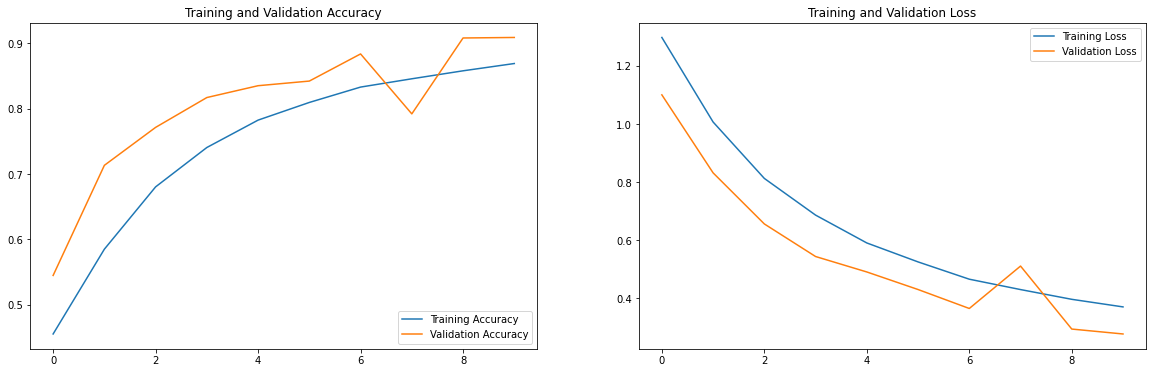

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### evaluate

In [30]:
model = results[choose_index][0]

In [31]:
model.evaluate(validation_dataset)

23/80 [=======>......................] - ETA: 0s - loss: 0.2827 - accuracy: 0.9158

2022-05-30 17:57:35.519722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 0s 4ms/step - loss: 0.2777 - accuracy: 0.9088


[0.2777068018913269, 0.9087691903114319]

In [32]:
predict_val = model.predict(validation_dataset).argmax(axis=1)
predict_val.shape, validation_label.shape

2022-05-30 17:57:35.971427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


((5086,), (5086,))

In [33]:
predict_val[40:46], validation_label[40:46]

(array([2, 1, 3, 2, 0, 3]),
 40    2.0
 41    1.0
 42    3.0
 43    2.0
 44    0.0
 45    3.0
 Name: 4, dtype: float32)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
# import seaborn as sns
# sns.heatmap(confusion_matrix(validation_label, predict_val), annot=True)

In [36]:
#Accuracy of the predicted values
print(classification_report(validation_label, predict_val)) 

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1245
         1.0       0.96      0.88      0.91      1672
         2.0       0.83      0.96      0.89      1315
         3.0       0.97      0.95      0.96       547
         4.0       0.98      0.72      0.83       307

    accuracy                           0.91      5086
   macro avg       0.93      0.89      0.90      5086
weighted avg       0.91      0.91      0.91      5086



In [37]:
import pandas as pd
# import warnings
# warnings.filterwarnings('always')

report = classification_report(validation_label, predict_val, output_dict=True)

pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.910672,0.925301,0.917928,1245.000000
1.0,0.955614,0.875598,0.913858,1672.000000
2.0,0.828217,0.964259,0.891075,1315.000000
3.0,0.971857,0.946984,0.959259,547.000000
4.0,0.977778,0.716612,0.827068,307.000000
accuracy,0.908769,0.908769,0.908769,0.908769
macro avg,0.928828,0.885751,0.901838,5086.000000
weighted avg,0.914758,0.908769,0.908608,5086.000000
